In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import pandas.plotting as pd_plt
import matplotlib.colors as plt_colors
from IPython.display import display, display_html, Math, Latex

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.metrics import log_loss, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import validation_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
from collections import OrderedDict
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [3]:
#conda install numpy=1.26

In [5]:
#pip install numpy==1.26.4 matplotlib pandas scikit-learn

In [7]:
#pip uninstall -y numpy matplotlib pandas scikit-learn

In [13]:
train = pd.read_csv('train.csv')
train

,id,recency,history,mens,womens,newbie,zip_code,channel,history_segment,segment,visit
0,1513,2,626.69,1,1,1,Urban,Phone,5) $500 - $750,Womens E-Mail,1
1,22507,10,121.20,0,1,1,Urban,Phone,2) $100 - $200,No E-Mail,0
2,20245,3,204.67,1,0,1,Urban,Multichannel,3) $200 - $350,No E-Mail,0
3,35147,10,62.76,0,1,1,Urban,Web,1) $0 - $100,No E-Mail,0
4,24319,12,189.15,1,0,0,Urban,Web,2) $100 - $200,No E-Mail,0
...,...,...,...,...,...,...,...,...,...,...,...
47995,46873,5,29.69,0,1,0,Surburban,Web,1) $0 - $100,No E-Mail,0
47996,50673,4,30.08,0,1,1,Rural,Web,1) $0 - $100,Womens E-Mail,0
47997,28914,7,129.37,0,1,1,Surburban,Phone,2) $100 - $200,Womens E-Mail,0
47998,11753,6,29.85,1,0,1,Surburban,Web,1) $0 - $100,Mens E-Mail,1


### Описание данных
- id — уникальный идентификатор наблюдения  
*Числовые признаки:*  
- recency (давность последнего взаимодействия, условные месяцы)  
- history (суммарная история покупок/транзакций/сумма)  
*Бинарные признаки:*  
- mens, womens (интересы клиента к мужским/женским товарам)  
- newbie (новый клиент)  
*Категориальные признаки:*  
- zip_code (география)  
- channel (канал взаимодействия)  
- history_segment (интервал, которому принадлжит history, сегмент покупательной способности)  

**Действие (лог):** segment — какое именно действие назначено (только в train)
  | Действие          | Описание                                          |
| ----------------- | ------------------------------------------------- |
| **Womens E-Mail** | Отправить пользователю e-mail с женскими товарами |
| **Mens E-Mail**   | Отправить e-mail с мужскими товарами              |
| **No E-Mail**     | Ничего не отправлять          |

**Цель (reward):** visit — бинарный исход «был визит на сайт» после отправки e-mail  

Нужно научиться принимать решение, что лучше отправить каждому новому пользователю, чтобы повысить вероятность визита.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               48000 non-null  int64  
 1   recency          48000 non-null  int64  
 2   history          48000 non-null  float64
 3   mens             48000 non-null  int64  
 4   womens           48000 non-null  int64  
 5   newbie           48000 non-null  int64  
 6   zip_code         48000 non-null  object 
 7   channel          48000 non-null  object 
 8   history_segment  48000 non-null  object 
 9   segment          48000 non-null  object 
 10  visit            48000 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 4.0+ MB


In [7]:
train.describe()

,id,recency,history,mens,womens,newbie,visit
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,32017.960167,5.765667,241.635397,0.550292,0.551104,0.501812,0.146833
std,18462.075268,3.510266,255.537956,0.497470,0.497387,0.500002,0.353943
min,3.000000,1.000000,29.450000,0.000000,0.000000,0.000000,0.000000
25%,16045.750000,2.000000,64.640000,0.000000,0.000000,0.000000,0.000000
50%,31999.000000,5.000000,157.730000,1.000000,1.000000,1.000000,0.000000
75%,47983.250000,9.000000,325.252500,1.000000,1.000000,1.000000,0.000000
max,64000.000000,12.000000,3041.930000,1.000000,1.000000,1.000000,1.000000


In [9]:
train.visit.value_counts() #неравномерно

visit
0    40952
1     7048
Name: count, dtype: int64

#### Пропенсити логирующей политики $μ(a∣x) = 1/3$ 

In [11]:
train['segment'].value_counts(normalize=True)

segment
Womens E-Mail    0.334167
No E-Mail        0.332917
Mens E-Mail      0.332917
Name: proportion, dtype: float64

In [15]:
# Новые колонки взаимодействий:

train['mens_interaction_history'] = train['mens']*train['history']
train['mens_interaction_recency'] = train['mens']*train['recency']

train['womens_interaction_history'] = train['womens']*train['history']
train['womens_interaction_recency'] = train['womens']*train['recency']

train['newbie_interaction_history'] = train['newbie']*train['history']
train['newbie_interaction_recency'] = train['newbie']*train['recency']

#### Разделим на train и test

In [18]:
X = train.drop(['segment', 'visit', 'history_segment'], axis=1) 
y = train[['segment', 'visit']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    test_size=0.2, stratify=y.segment)
X_train.head(3)

,id,recency,history,mens,womens,newbie,zip_code,channel,mens_interaction_history,mens_interaction_recency,womens_interaction_history,womens_interaction_recency,newbie_interaction_history,newbie_interaction_recency
39397,54756,11,291.89,1,1,0,Urban,Multichannel,291.89,11,291.89,11,0.00,0
8619,35576,12,42.76,1,0,1,Surburban,Phone,42.76,12,0.00,0,42.76,12
26807,18177,6,137.49,1,0,0,Urban,Web,137.49,6,0.00,0,0.00,0


#### Column Transformer

In [20]:
cat_features = ["zip_code", "channel"] 
num_features = ['recency', 'history', 'id'] 
interaction_features = ['mens_interaction_history','mens_interaction_recency','womens_interaction_history',
                   'womens_interaction_recency','newbie_interaction_history','newbie_interaction_recency']

num = Pipeline(steps=[
    #('poly', PolynomialFeatures(degree=3)), # Добавляем PolynomialFeatures(перемножение признаков до 3 степени)
    ('scaler', StandardScaler()) #стандартизируем
])

cat = Pipeline(steps=[ 
    ('onehot', OneHotEncoder(sparse_output=False)) #перекодируем категориальные признаки в числовые
    
    ])

inter = Pipeline(steps=[
    ('scaler', StandardScaler())
])   

CT = ColumnTransformer(
    transformers=[
        ("num", num, num_features),
        ("cat", cat, cat_features),
        ("inter", inter, interaction_features)
    ],
    remainder='passthrough'  
).set_output(transform='pandas')

display(CT)

ct = CT.fit_transform(X_train)
pd.DataFrame(ct).head()

,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


,num__recency,num__history,num__id,cat__zip_code_Rural,cat__zip_code_Surburban,cat__zip_code_Urban,cat__channel_Multichannel,cat__channel_Phone,cat__channel_Web,inter__mens_interaction_history,inter__mens_interaction_recency,inter__womens_interaction_history,inter__womens_interaction_recency,inter__newbie_interaction_history,inter__newbie_interaction_recency,remainder__mens,remainder__womens,remainder__newbie
39397,1.494291,0.196801,1.231453,0.0,0.0,1.0,1.0,0.0,0.0,0.596299,2.058712,0.589746,2.049242,-0.544583,-0.748870,1,1,0
8619,1.779419,-0.778711,0.192574,0.0,1.0,0.0,0.0,1.0,0.0,-0.431152,2.319947,-0.605206,-0.812548,-0.388579,2.458812,1,0,1
26807,0.068653,-0.407779,-0.749838,0.0,0.0,1.0,0.0,0.0,1.0,-0.040471,0.752535,-0.605206,-0.812548,-0.544583,-0.748870,1,0,0
10325,-1.356985,-0.829419,-1.207638,0.0,0.0,1.0,0.0,0.0,1.0,-0.484560,-0.553642,-0.605206,-0.812548,-0.435825,-0.481563,1,0,1
30989,-0.216474,-0.645500,-0.848797,1.0,0.0,0.0,0.0,0.0,1.0,-0.607501,-0.814878,-0.290880,0.488266,-0.544583,-0.748870,0,1,0


#### Бенчмарк «лучшая статическая политика»

In [22]:
m_i = np.full(len(y_test), 1/3)

#Посчитаем V_statistics(a)
V_stats = (
    y_test
    .assign(r_over_m = y_test['visit'] / m_i, one_over_m = 1 / m_i)
    .groupby('segment', as_index=False)
    .agg({'r_over_m': 'sum', 'one_over_m': 'sum'})
)
V_stats['V_statistics'] = V_stats['r_over_m'] / V_stats['one_over_m']

#Найдём лучшую статическую политику
V_best = V_stats['V_statistics'].max()
best_action = V_stats.loc[V_stats['V_statistics'].idxmax(), 'segment']

print("V_statistics per action:")
print(V_stats[['segment', 'V_statistics']])
print("\nBest static policy:")
print(f"{best_action} with V_best = {V_best:.6f}")

V_statistics per action:
         segment  V_statistics
0    Mens E-Mail      0.178035
1      No E-Mail      0.096683
2  Womens E-Mail      0.151808

Best static policy:
Mens E-Mail with V_best = 0.178035


## Подбор для reward моделей

#### Разбиваем train по действиям

In [24]:
train_mens = X_train[y_train.segment == 'Mens E-Mail']
y_mens = y_train.loc[y_train.segment == 'Mens E-Mail', 'visit']

train_womens = X_train[y_train.segment == 'Womens E-Mail']
y_womens = y_train.loc[y_train.segment == 'Womens E-Mail', 'visit']

train_none = X_train[y_train.segment == 'No E-Mail']
y_none = y_train.loc[y_train.segment == 'No E-Mail', 'visit']

### 1-ая reward модель: Mens E-Mail

In [26]:
X_tr, X_val, y_tr, y_val = train_test_split(train_mens, y_mens, test_size = 0.2, stratify = y_mens)

In [58]:
#с class_weights стало хуже
# class_weights = compute_class_weight('balanced', classes=np.unique(y_mens), y=y_mens)
# weight_dict = dict(zip(np.unique(y_mens), class_weights))

# print("Веса классов:", weight_dict)

Веса классов: {0: 0.6109146516295517, 1: 2.753985351141749}


#### Логистическая регрессия

In [28]:
pipe = Pipeline(steps=[
    ('preprocessor', CT),
    ('classifier', LogisticRegression(max_iter=100000))
])

param_grid = [
    {
        'classifier__penalty': ['l2'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier__penalty': ['l1'],
        'classifier__solver': ['liblinear'],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier__penalty': [None],
        'classifier__solver': ['lbfgs', 'newton-cg']
    }
]

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, train_size=0.75, random_state=42)


grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='neg_log_loss',   
    return_train_score=True
)

grid.fit(X_tr, y_tr)

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средний log loss на CV: {:.6f}".format(-grid.best_score_))

y_pred_proba = grid.predict_proba(X_val)
print("Log loss на валидации: {:.6f}".format(log_loss(y_val, y_pred_proba)))

grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score", "std_test_score"]).T
grid_result

----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}

Средний log loss на CV: 0.464002
Log loss на валидации: 0.465149


,10,13,14,18,19,22,23,24,29,17,...,8,9,7,1,3,4,0,26,2,25
mean_fit_time,0.017992,0.459149,0.748182,1.305752,1.286655,0.022736,0.100414,0.189895,0.105988,0.022524,...,0.108242,0.230832,0.01919,0.013122,0.025059,0.060641,0.020327,0.046376,0.01611,0.019155
std_fit_time,0.001497,0.043877,0.084217,0.098966,0.287833,0.00204,0.02113,0.027905,0.01153,0.002452,...,0.017847,0.040058,0.00482,0.002619,0.001895,0.007111,0.015088,0.015555,0.001487,0.000621
mean_score_time,0.003398,0.003674,0.003059,0.003186,0.004746,0.006815,0.004951,0.004185,0.003951,0.004393,...,0.0043,0.005693,0.007351,0.004379,0.004935,0.004617,0.004121,0.005736,0.00387,0.003883
std_score_time,0.000628,0.001303,0.000033,0.000111,0.002987,0.003811,0.002085,0.001712,0.001794,0.001402,...,0.001624,0.001893,0.005194,0.00162,0.001593,0.002068,0.002164,0.001972,0.001769,0.001217
param_classifier__C,1.0,1.0,1.0,10.0,10.0,100.0,100.0,100.0,100.0,10.0,...,0.1,0.1,0.1,0.01,0.01,0.01,0.01,0.1,0.01,0.01
param_classifier__penalty,l2,l2,l2,l2,l2,l2,l2,l2,l1,l2,...,l2,l2,l2,l2,l2,l2,l2,l1,l2,l1
param_classifier__solver,newton-cg,sag,saga,sag,saga,liblinear,sag,saga,liblinear,liblinear,...,sag,saga,liblinear,lbfgs,sag,saga,newton-cg,liblinear,liblinear,liblinear
params,"{'classifier__C': 1, 'classifier__penalty': 'l...","{'classifier__C': 1, 'classifier__penalty': 'l...","{'classifier__C': 1, 'classifier__penalty': 'l...","{'classifier__C': 10, 'classifier__penalty': '...","{'classifier__C': 10, 'classifier__penalty': '...","{'classifier__C': 100, 'classifier__penalty': ...","{'classifier__C': 100, 'classifier__penalty': ...","{'classifier__C': 100, 'classifier__penalty': ...","{'classifier__C': 100, 'classifier__penalty': ...","{'classifier__C': 10, 'classifier__penalty': '...",...,"{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':..."
split0_test_score,-0.465805,-0.465806,-0.465806,-0.46581,-0.46581,-0.465812,-0.465811,-0.465811,-0.46581,-0.465806,...,-0.465854,-0.465854,-0.465865,-0.465666,-0.465666,-0.465666,-0.465665,-0.465525,-0.46621,-0.4698
split1_test_score,-0.466293,-0.466294,-0.466296,-0.466267,-0.466268,-0.466263,-0.466264,-0.466266,-0.46627,-0.466277,...,-0.466411,-0.466413,-0.467143,-0.466632,-0.466633,-0.466633,-0.466641,-0.467452,-0.468826,-0.470703


##### Логрег с калибровкой

In [30]:
base_model = Pipeline(steps=[
    ('preprocessor', CT),
    ('classifier', LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000))
])
base_model.fit(X_tr, y_tr)

#логлосс ДО калибровки
y_pred_base = base_model.predict_proba(X_val)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val, y_val)

#логлосс ПОСЛЕ 
y_pred_cal = calibrated.predict_proba(X_val)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.465185
Log-loss после калибровки: 0.460494


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Градиентный бустинг


 Обучаем модель с learning_rate=0.005


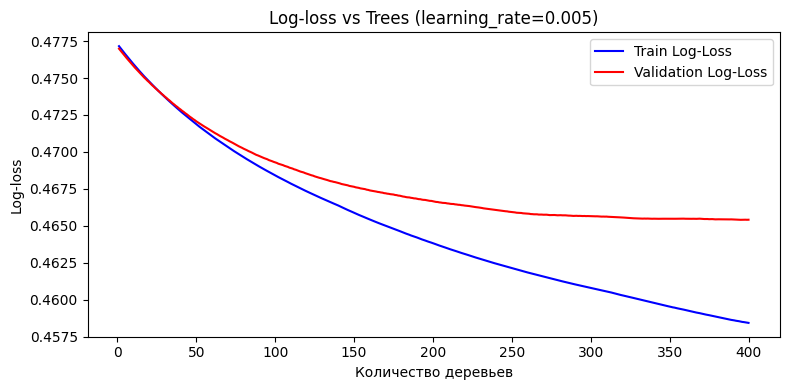

Log-loss на валидации (0.005): 0.465413

 Обучаем модель с learning_rate=0.01


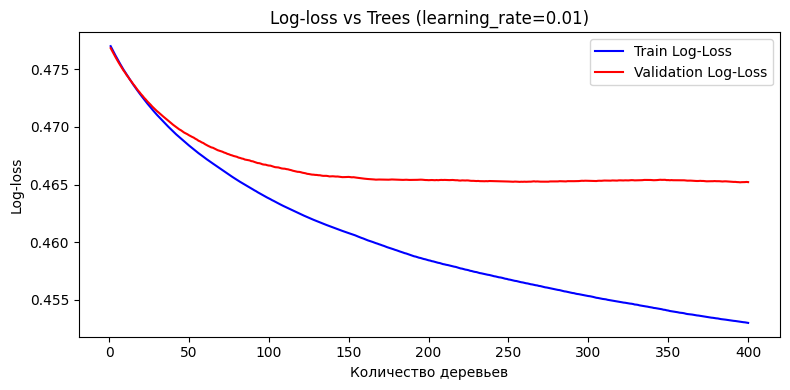

Log-loss на валидации (0.01): 0.465212

 Обучаем модель с learning_rate=0.05


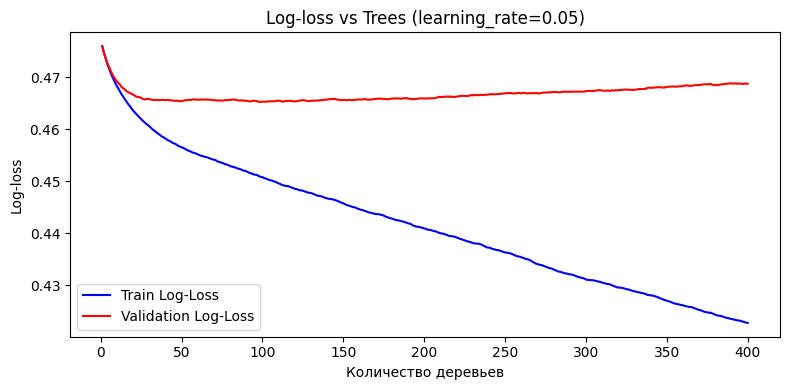

Log-loss на валидации (0.05): 0.468727

 Обучаем модель с learning_rate=0.1


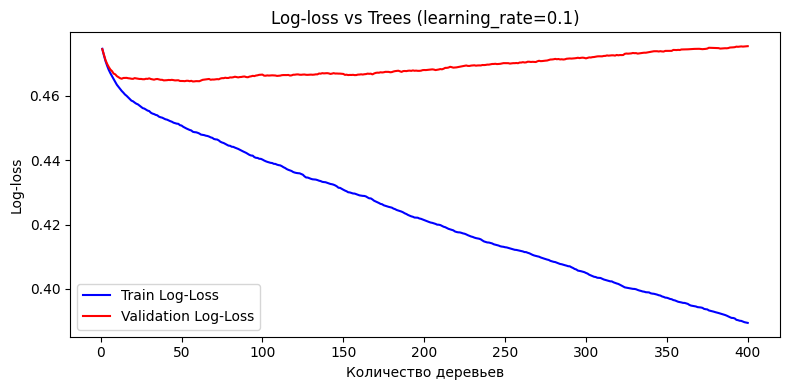

Log-loss на валидации (0.1): 0.475458


In [32]:
X_tr_enc = CT.fit_transform(X_tr)
X_val_enc = CT.transform(X_val)

#Функция для построения log-loss
def plot_learning_tree_logloss(estimator, X_tr, X_val, y_tr, y_val, learning_rate=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    n_estimators = estimator.n_estimators_
    zero = np.zeros(n_estimators, dtype=np.float64)

    #на train
    train_loss = zero.copy()
    for i, y_pred_train in enumerate(estimator.staged_predict_proba(X_tr)):
        train_loss[i] = log_loss(y_tr, y_pred_train)

    #на validation
    val_loss = zero.copy()
    for i, y_pred_val in enumerate(estimator.staged_predict_proba(X_val)):
        val_loss[i] = log_loss(y_val, y_pred_val)

    ax.plot(np.arange(1, n_estimators + 1), train_loss, '-', color='blue', label='Train Log-Loss')
    ax.plot(np.arange(1, n_estimators + 1), val_loss, '-', color='red', label='Validation Log-Loss')

    ax.legend(loc='best')
    ax.set_title(f'Log-loss vs Trees (learning_rate={learning_rate})')
    ax.set_xlabel('Количество деревьев')
    ax.set_ylabel('Log-loss')
    plt.tight_layout()
    plt.show()

#Обучаем модели с разными learning_rate
for lr in [0.005, 0.01, 0.05, 0.1]:
    print(f"\n Обучаем модель с learning_rate={lr}")
    clf = GradientBoostingClassifier(
        n_estimators=400,
        learning_rate=lr,
        random_state=42
    )
    clf.fit(X_tr_enc, y_tr)

    
    plot_learning_tree_logloss(clf, X_tr_enc, X_val_enc, y_tr, y_val, learning_rate=lr)

    y_pred_val = clf.predict_proba(X_val_enc)
    print(f"Log-loss на валидации ({lr}): {log_loss(y_val, y_pred_val):.6f}")

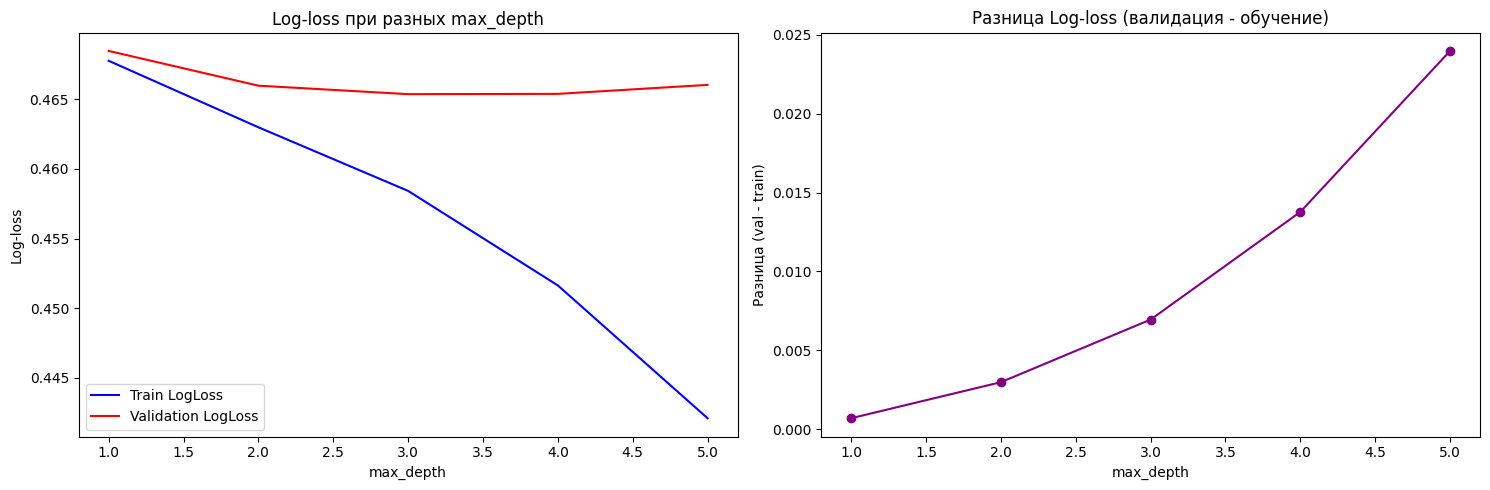

In [34]:
original_params = {
    "n_estimators": 200,
    "learning_rate": 0.01,
    "random_state": 42
}

max_depths = range(1, 6)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_logloss = []
val_logloss = []

#Перебор max_depth 
for depth in max_depths:
    params = dict(original_params)
    params["max_depth"] = depth
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_tr_enc, y_tr)

    # Log-loss
    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация
axes[0].plot(max_depths, train_logloss, label="Train LogLoss", color="blue")
axes[0].plot(max_depths, val_logloss, label="Validation LogLoss", color="red")
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("Log-loss")
axes[0].legend()
axes[0].set_title("Log-loss при разных max_depth")

#разница train-val 
axes[1].plot(max_depths, [v - t for v, t in zip(val_logloss, train_logloss)], 
             color="purple", marker='o')
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("Разница (val - train)")
axes[1].set_title("Разница Log-loss (валидация - обучение)")

plt.tight_layout()
plt.show()

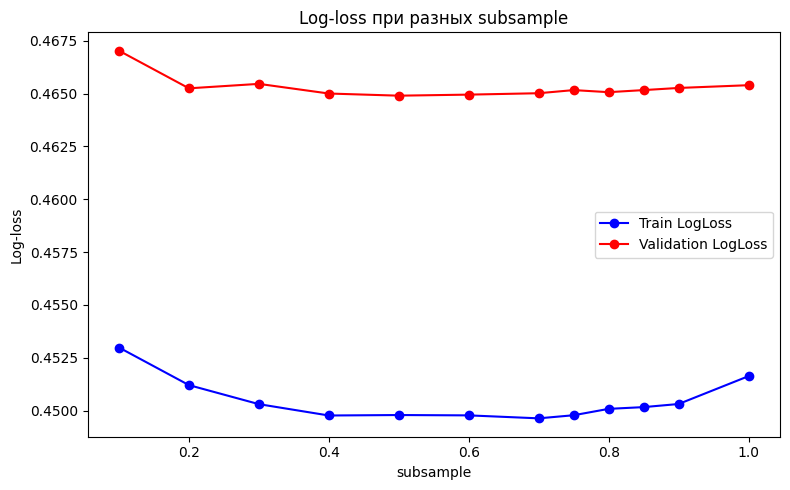

In [36]:
original_params = {
    "n_estimators": 200,
    "learning_rate": 0.01,
    "max_depth": 4,
    "random_state": 42
}

subsamples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

fig, ax = plt.subplots(figsize=(8, 5))

train_logloss = []
val_logloss = []

#Перебор subsample
for subsample_val in subsamples:
    params = dict(original_params)
    params["subsample"] = subsample_val
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_tr_enc, y_tr)

    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация
ax.plot(subsamples, train_logloss, label="Train LogLoss", color="blue", marker="o")
ax.plot(subsamples, val_logloss, label="Validation LogLoss", color="red", marker="o")
ax.set_xlabel("subsample")
ax.set_ylabel("Log-loss")
ax.legend(loc='best')
ax.set_title("Log-loss при разных subsample")

plt.tight_layout()
plt.show()

##### С калибровкой

In [38]:
base_model = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.01, max_depth = 4, subsample = 0.6)
base_model.fit(X_tr_enc, y_tr)

#логлосс ДО
y_pred_base = base_model.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка модели
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val_enc, y_val)

#логлосс ПОСЛЕ
y_pred_cal = calibrated.predict_proba(X_val_enc)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.464789
Log-loss после калибровки: 0.460158


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### RandomForest

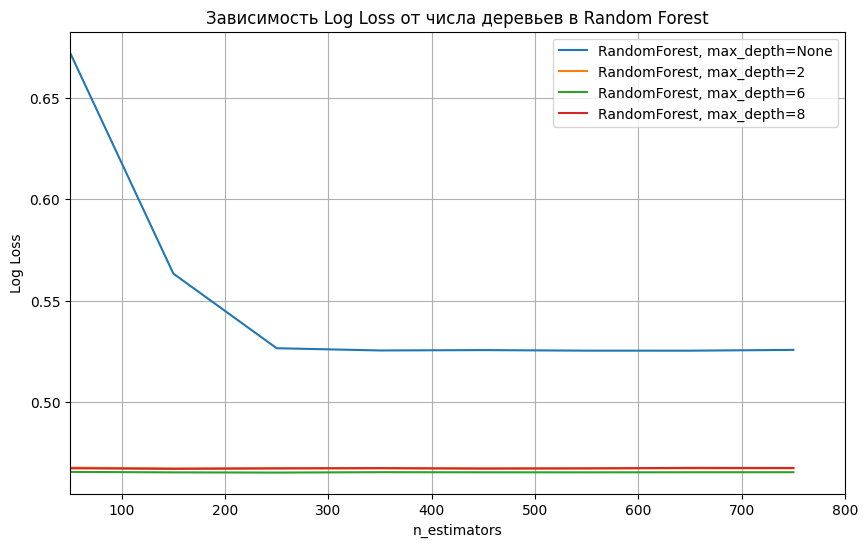

In [40]:
RANDOM_STATE = 42 

#Разные глубины деревьев
ensemble_clfs = [
    ("RandomForest, max_depth=None", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=None,
    )),
    ("RandomForest, max_depth=2", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=2,
    )),
    ("RandomForest, max_depth=6", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=6,
    )),
    ("RandomForest, max_depth=8", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=8,
    )),
]

#Хранилище результатов
logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)
        y_pred_proba = clf.predict_proba(X_val_enc)
        score = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, score))

#Визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.title("Зависимость Log Loss от числа деревьев в Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.show()

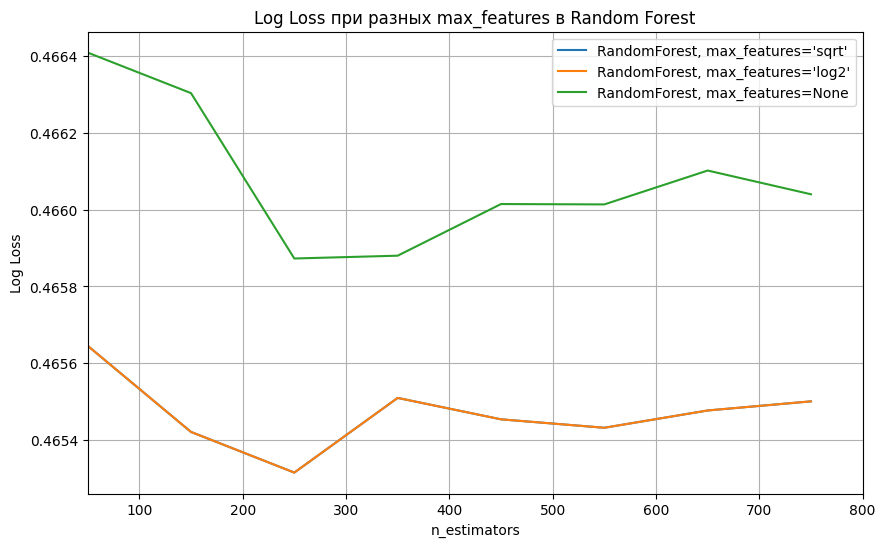

In [42]:
ensemble_clfs = [
    (
        "RandomForest, max_features='sqrt'",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, max_features='log2'",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="log2",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, max_features=None",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features=None,
            random_state=RANDOM_STATE,
        ),
    ),
]

logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)

        y_pred_proba = clf.predict_proba(X_val_enc)
        logloss = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, logloss))

#Визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.legend(loc="best")
plt.title("Log Loss при разных max_features в Random Forest")
plt.grid(True)
plt.show()

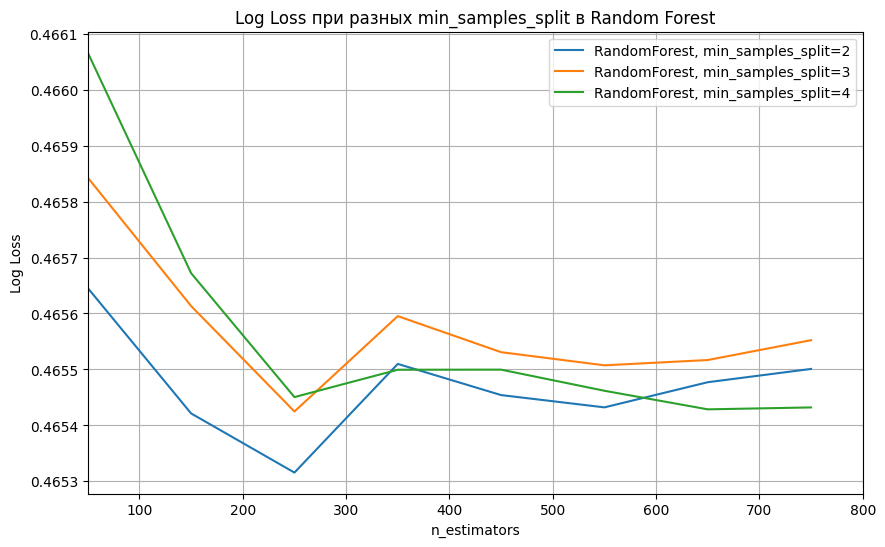

In [44]:
ensemble_clfs = [
    (
        "RandomForest, min_samples_split=2",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=2,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_split=3",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=3,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_split=4",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=4,
            random_state=RANDOM_STATE,
        ),
    ),
]

logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)

        y_pred_proba = clf.predict_proba(X_val_enc)
        loss = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, loss))

#Визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.title("Log Loss при разных min_samples_split в Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.show()

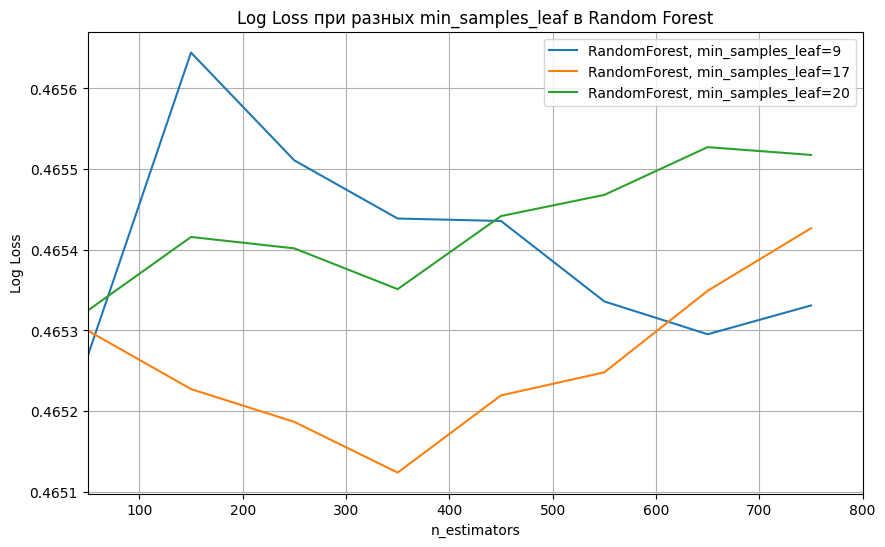

In [46]:
ensemble_clfs = [
    (
        "RandomForest, min_samples_leaf=9",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=2,
            min_samples_leaf=9,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_leaf=17",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=2,
            min_samples_leaf=17,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_leaf=20",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=2,
            min_samples_leaf=20,
            random_state=RANDOM_STATE,
        ),
    ),
]

logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)

        y_pred_proba = clf.predict_proba(X_val_enc)
        loss = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, loss))

# визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.title("Log Loss при разных min_samples_leaf в Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [48]:
base_model = RandomForestClassifier(n_estimators=350, oob_score = True, max_depth = 6, min_samples_leaf=17,
                                  max_features="sqrt", min_samples_split = 2, n_jobs=-1)
base_model.fit(X_tr_enc, y_tr)

#логлосс ДО
y_pred_base = base_model.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка 
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val_enc, y_val)

#логлосс ПОСЛЕ 
y_pred_cal = calibrated.predict_proba(X_val_enc)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.465652
Log-loss после калибровки: 0.461841


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### KNN

In [134]:
pipe = Pipeline(steps=[
    ('preprocessor', CT),
    ('knn', KNeighborsClassifier(weights='distance'))
])

logloss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

#Кросс-валидация
cv = StratifiedShuffleSplit(test_size=0.25, train_size=0.75, n_splits=5, random_state=42)


param_grid = [{
    'knn__n_neighbors': [100, 700, 800, 900],
    'knn__p': [1, 2, 3]
}]


grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    return_train_score=True,
    scoring=logloss_scorer
)

grid.fit(X_tr, y_tr)

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))

y_val_proba = grid.predict_proba(X_val)
val_logloss = log_loss(y_val, y_val_proba)
print(f"Log-loss на валидации: {val_logloss:.6f}\n")

grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'knn__n_neighbors': 900, 'knn__p': 1}

Log-loss на валидации: 0.476252



,9,6,3,10,7,4,0,11,8,5,1,2
mean_fit_time,0.013019,0.016951,0.01186,0.011767,0.010856,0.012277,0.012526,0.012598,0.016863,0.013647,0.014839,0.011552
std_fit_time,0.004045,0.011121,0.000697,0.000984,0.001258,0.000412,0.009737,0.002742,0.008828,0.003484,0.002677,0.001364
mean_score_time,1.315771,1.11412,0.283284,1.643987,0.957596,0.246275,0.17439,2.05787,1.529881,1.299908,0.202621,0.865576
std_score_time,0.624263,0.451375,0.013757,0.372059,0.322592,0.01456,0.079636,0.740975,0.479113,0.2315,0.058853,0.145091
param_knn__n_neighbors,900,800,700,900,800,700,100,900,800,700,100,100
param_knn__p,1,1,1,2,2,2,1,3,3,3,2,3
params,"{'knn__n_neighbors': 900, 'knn__p': 1}","{'knn__n_neighbors': 800, 'knn__p': 1}","{'knn__n_neighbors': 700, 'knn__p': 1}","{'knn__n_neighbors': 900, 'knn__p': 2}","{'knn__n_neighbors': 800, 'knn__p': 2}","{'knn__n_neighbors': 700, 'knn__p': 2}","{'knn__n_neighbors': 100, 'knn__p': 1}","{'knn__n_neighbors': 900, 'knn__p': 3}","{'knn__n_neighbors': 800, 'knn__p': 3}","{'knn__n_neighbors': 700, 'knn__p': 3}","{'knn__n_neighbors': 100, 'knn__p': 2}","{'knn__n_neighbors': 100, 'knn__p': 3}"
split0_test_score,-0.480214,-0.480447,-0.48071,-0.4886,-0.489025,-0.489511,-0.489092,-0.492116,-0.492616,-0.493188,-0.502714,-0.508317
split1_test_score,-0.484596,-0.484846,-0.485254,-0.494779,-0.495269,-0.495933,-0.496117,-0.498742,-0.499317,-0.500076,-0.512249,-0.51846
split2_test_score,-0.479108,-0.479326,-0.479702,-0.48654,-0.486958,-0.487546,-0.488811,-0.489817,-0.490314,-0.490991,-0.501529,-0.50696


переобучается

In [137]:
base_model = Pipeline(steps=[
    ('preprocessor', CT),
    ('classifier', KNeighborsClassifier(weights='distance', n_neighbors = 600, p = 1))
])
base_model.fit(X_tr, y_tr)

#логлосс ДО 
y_pred_base = base_model.predict_proba(X_val)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val, y_val)

#логлосс ПОСЛЕ
y_pred_cal = calibrated.predict_proba(X_val)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.476942
Log-loss после калибровки: 0.471176


#### CatBoost

In [22]:
#X_tr_enc = CT.fit_transform(X_tr)
#X_val_enc = CT.transform(X_val)


 Обучаем модель с learning_rate=0.005
0:	learn: 0.6906543	test: 0.6906898	best: 0.6906898 (0)	total: 64.6ms	remaining: 1m 4s
100:	learn: 0.5389853	test: 0.5416005	best: 0.5416005 (100)	total: 259ms	remaining: 2.3s
200:	learn: 0.4881436	test: 0.4921206	best: 0.4921206 (200)	total: 447ms	remaining: 1.78s
300:	learn: 0.4696245	test: 0.4750257	best: 0.4750257 (300)	total: 640ms	remaining: 1.49s
400:	learn: 0.4618144	test: 0.4687284	best: 0.4687284 (400)	total: 831ms	remaining: 1.24s
500:	learn: 0.4577342	test: 0.4663849	best: 0.4663849 (500)	total: 1.02s	remaining: 1.02s
600:	learn: 0.4547234	test: 0.4655116	best: 0.4655116 (600)	total: 1.21s	remaining: 805ms
700:	learn: 0.4523172	test: 0.4652682	best: 0.4652465 (692)	total: 1.42s	remaining: 604ms
800:	learn: 0.4500367	test: 0.4651653	best: 0.4651485 (796)	total: 1.61s	remaining: 401ms
900:	learn: 0.4481492	test: 0.4653242	best: 0.4651485 (796)	total: 1.81s	remaining: 199ms
999:	learn: 0.4464398	test: 0.4653262	best: 0.4651485 (796)	total

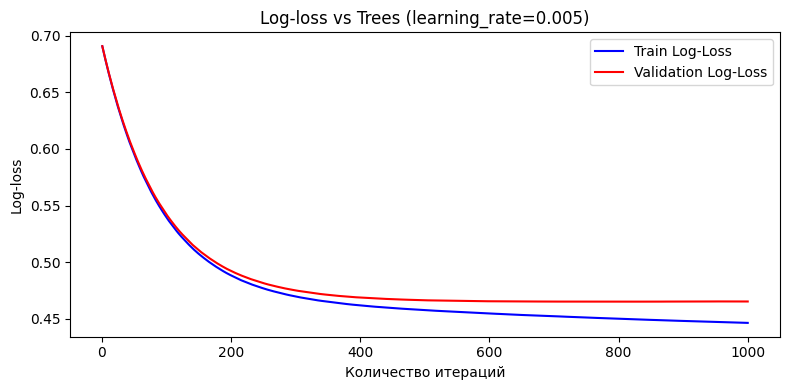

Log-loss на валидации (0.005): 0.465148
Лучшая итерация: 796

 Обучаем модель с learning_rate=0.01
0:	learn: 0.6881796	test: 0.6882475	best: 0.6882475 (0)	total: 3.19ms	remaining: 3.19s
100:	learn: 0.4872836	test: 0.4915716	best: 0.4915716 (100)	total: 245ms	remaining: 2.18s
200:	learn: 0.4615614	test: 0.4687612	best: 0.4687612 (200)	total: 432ms	remaining: 1.72s
300:	learn: 0.4541836	test: 0.4654677	best: 0.4654677 (300)	total: 628ms	remaining: 1.46s
400:	learn: 0.4495798	test: 0.4652021	best: 0.4650895 (342)	total: 823ms	remaining: 1.23s
500:	learn: 0.4456677	test: 0.4653846	best: 0.4650895 (342)	total: 1.02s	remaining: 1.01s
600:	learn: 0.4422643	test: 0.4656782	best: 0.4650895 (342)	total: 1.21s	remaining: 804ms
700:	learn: 0.4391072	test: 0.4659389	best: 0.4650895 (342)	total: 1.41s	remaining: 600ms
800:	learn: 0.4358769	test: 0.4662671	best: 0.4650895 (342)	total: 1.6s	remaining: 398ms
900:	learn: 0.4327725	test: 0.4664818	best: 0.4650895 (342)	total: 1.8s	remaining: 198ms
999:	l

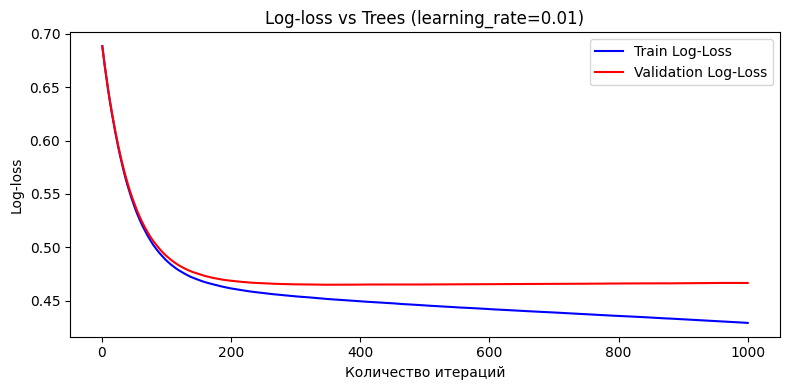

Log-loss на валидации (0.01): 0.465090
Лучшая итерация: 342

 Обучаем модель с learning_rate=0.05
0:	learn: 0.6689288	test: 0.6692502	best: 0.6692502 (0)	total: 3.31ms	remaining: 3.3s
100:	learn: 0.4462714	test: 0.4662840	best: 0.4657227 (74)	total: 265ms	remaining: 2.36s
200:	learn: 0.4294531	test: 0.4685697	best: 0.4657227 (74)	total: 475ms	remaining: 1.89s
300:	learn: 0.4119784	test: 0.4711971	best: 0.4657227 (74)	total: 672ms	remaining: 1.56s
400:	learn: 0.3960070	test: 0.4730718	best: 0.4657227 (74)	total: 869ms	remaining: 1.3s
500:	learn: 0.3826314	test: 0.4745445	best: 0.4657227 (74)	total: 1.07s	remaining: 1.07s
600:	learn: 0.3705970	test: 0.4768392	best: 0.4657227 (74)	total: 1.28s	remaining: 850ms
700:	learn: 0.3589661	test: 0.4792435	best: 0.4657227 (74)	total: 1.49s	remaining: 634ms
800:	learn: 0.3480645	test: 0.4811310	best: 0.4657227 (74)	total: 1.7s	remaining: 422ms
900:	learn: 0.3382700	test: 0.4831352	best: 0.4657227 (74)	total: 1.93s	remaining: 212ms
999:	learn: 0.328

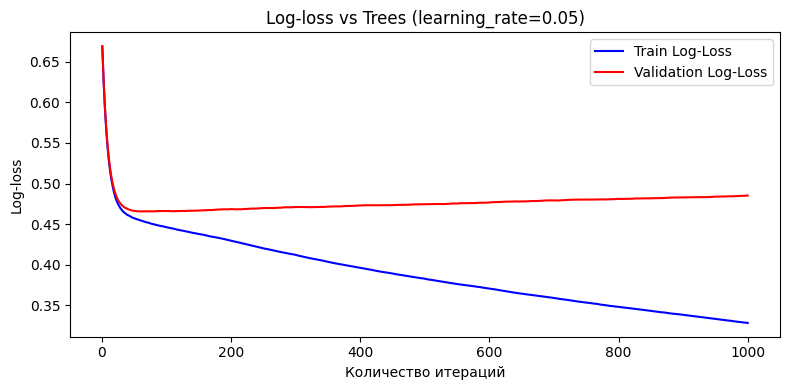

Log-loss на валидации (0.05): 0.465723
Лучшая итерация: 74

 Обучаем модель с learning_rate=0.1
0:	learn: 0.6462522	test: 0.6468541	best: 0.6468541 (0)	total: 3.6ms	remaining: 3.59s
100:	learn: 0.4298729	test: 0.4667713	best: 0.4650071 (32)	total: 256ms	remaining: 2.27s
200:	learn: 0.3975615	test: 0.4697331	best: 0.4650071 (32)	total: 451ms	remaining: 1.79s
300:	learn: 0.3700171	test: 0.4757877	best: 0.4650071 (32)	total: 648ms	remaining: 1.5s
400:	learn: 0.3475005	test: 0.4811334	best: 0.4650071 (32)	total: 853ms	remaining: 1.27s
500:	learn: 0.3268459	test: 0.4880143	best: 0.4650071 (32)	total: 1.06s	remaining: 1.05s
600:	learn: 0.3085997	test: 0.4926703	best: 0.4650071 (32)	total: 1.26s	remaining: 840ms
700:	learn: 0.2914950	test: 0.4957200	best: 0.4650071 (32)	total: 1.47s	remaining: 627ms
800:	learn: 0.2767024	test: 0.5008307	best: 0.4650071 (32)	total: 1.67s	remaining: 414ms
900:	learn: 0.2629705	test: 0.5059755	best: 0.4650071 (32)	total: 1.86s	remaining: 205ms
999:	learn: 0.2504

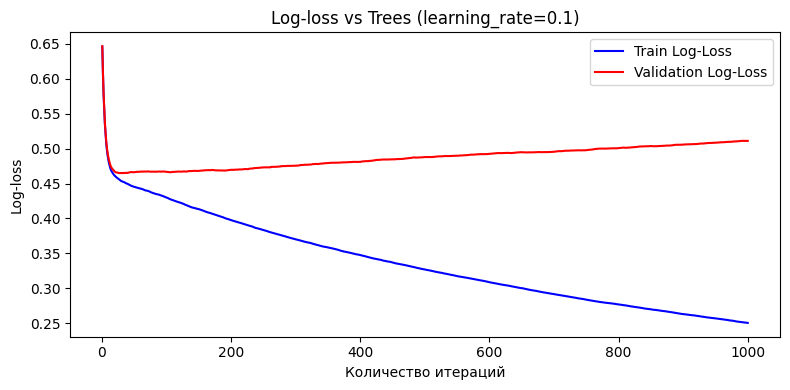

Log-loss на валидации (0.1): 0.465007
Лучшая итерация: 32


In [50]:
def plot_catboost_learning_curve(estimator, learning_rate=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    evals_result = estimator.get_evals_result()
    
    if 'learn' in evals_result and 'validation' in evals_result:
        train_loss = evals_result['learn']['Logloss']
        val_loss = evals_result['validation']['Logloss']
        
        ax.plot(np.arange(1, len(train_loss) + 1), train_loss, '-', color='blue', label='Train Log-Loss')
        ax.plot(np.arange(1, len(val_loss) + 1), val_loss, '-', color='red', label='Validation Log-Loss')
        
        ax.legend(loc='best')
        ax.set_title(f'Log-loss vs Trees (learning_rate={learning_rate})')
        ax.set_xlabel('Количество итераций')
        ax.set_ylabel('Log-loss')
        plt.tight_layout()
        plt.show()
    else:
        print("История обучения недоступна")

# Обучаем модели
for lr in [0.005, 0.01, 0.05, 0.1]:
    print(f"\n Обучаем модель с learning_rate={lr}")
    clf = CatBoostClassifier(
        iterations=1000,
        learning_rate=lr,
        random_state=42,
        verbose=100,
        eval_metric='Logloss'
    )
    
    clf.fit(
        X_tr_enc, y_tr,
        eval_set=(X_val_enc, y_val),
        verbose=100
    )

    plot_catboost_learning_curve(clf, learning_rate=lr)
    
    y_pred_val = clf.predict_proba(X_val_enc)
    print(f"Log-loss на валидации ({lr}): {log_loss(y_val, y_pred_val):.6f}")
    print(f"Лучшая итерация: {clf.get_best_iteration()}")

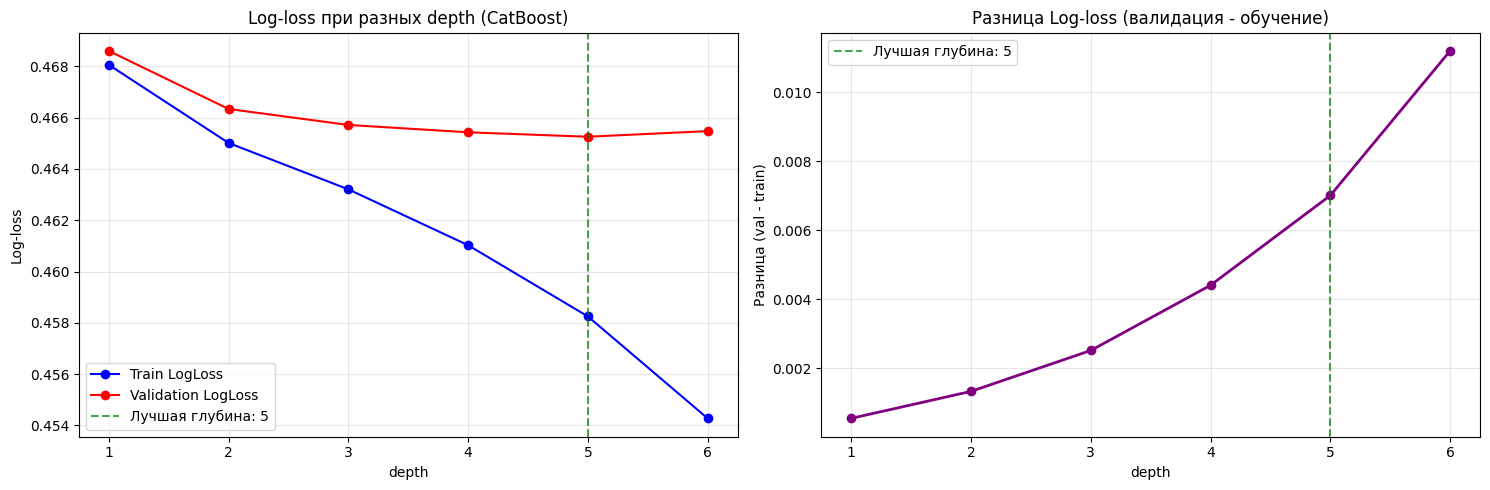


Лучшая глубина: 5
Лучший log-loss на валидации: 0.4653


In [54]:
original_params = {
    "iterations": 300,  
    "learning_rate": 0.01,
    "random_state": 42,
    "verbose": False  
}

max_depths = range(1, 7)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_logloss = []
val_logloss = []

#Перебор max_depth 
for depth in max_depths:
    params = dict(original_params)
    params["depth"] = depth  
    
    clf = CatBoostClassifier(**params)
    clf.fit(X_tr_enc, y_tr, eval_set=(X_val_enc, y_val), verbose=False)

    # Log-loss
    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)
    

# Визуализация
axes[0].plot(max_depths, train_logloss, label="Train LogLoss", color="blue", marker='o')
axes[0].plot(max_depths, val_logloss, label="Validation LogLoss", color="red", marker='o')
axes[0].set_xlabel("depth")
axes[0].set_ylabel("Log-loss")
axes[0].legend()
axes[0].set_title("Log-loss при разных depth (CatBoost)")
axes[0].grid(True, alpha=0.3)

#Разница train-val 
axes[1].plot(max_depths, [v - t for v, t in zip(val_logloss, train_logloss)], 
             color="purple", marker='o', linewidth=2)
axes[1].set_xlabel("depth")
axes[1].set_ylabel("Разница (val - train)")
axes[1].set_title("Разница Log-loss (валидация - обучение)")
axes[1].grid(True, alpha=0.3)

best_depth_idx = np.argmin(val_logloss)
best_depth = max_depths[best_depth_idx]
axes[0].axvline(x=best_depth, color='green', linestyle='--', alpha=0.7, 
                label=f'Лучшая глубина: {best_depth}')
axes[0].legend()

axes[1].axvline(x=best_depth, color='green', linestyle='--', alpha=0.7,
                label=f'Лучшая глубина: {best_depth}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nЛучшая глубина: {best_depth}")
print(f"Лучший log-loss на валидации: {val_logloss[best_depth_idx]:.4f}")

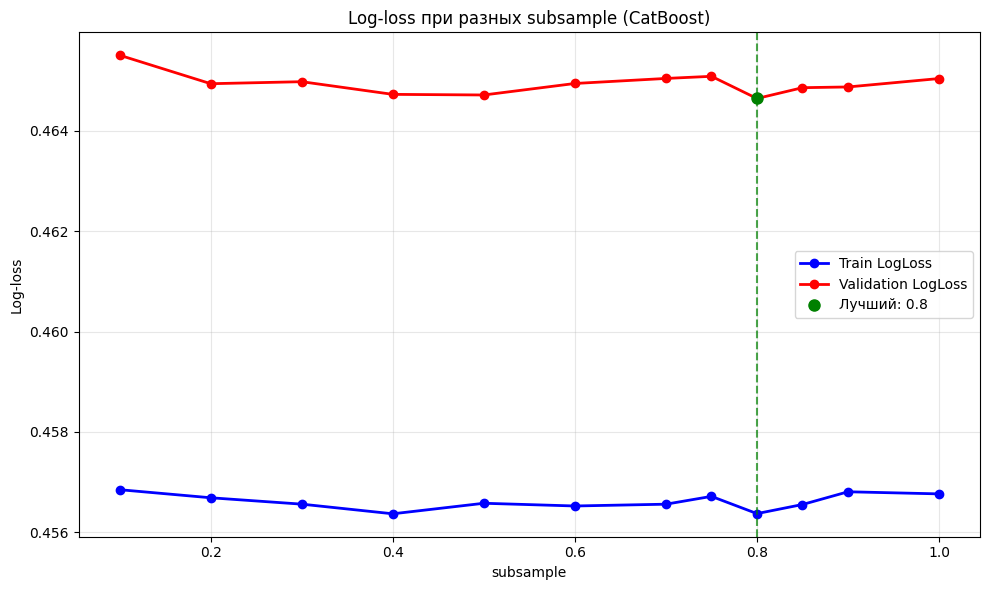


Лучший subsample: 0.8
Log-loss на валидации: 0.4646


In [56]:
original_params = {
    "iterations": 350,  
    "learning_rate": 0.01,
    "depth": 5,         
    "random_state": 42,
    "verbose": False    
}

subsamples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

fig, ax = plt.subplots(figsize=(10, 6))

train_logloss = []
val_logloss = []

#Перебор subsample
for subsample_val in subsamples:
    params = dict(original_params)
    params["subsample"] = subsample_val
    clf = CatBoostClassifier(**params)
    clf.fit(X_tr_enc, y_tr, eval_set=(X_val_enc, y_val), verbose=False)

    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация
ax.plot(subsamples, train_logloss, label="Train LogLoss", color="blue", marker="o", linewidth=2)
ax.plot(subsamples, val_logloss, label="Validation LogLoss", color="red", marker="o", linewidth=2)
ax.set_xlabel("subsample")
ax.set_ylabel("Log-loss")
ax.legend(loc='best')
ax.set_title("Log-loss при разных subsample (CatBoost)")
ax.grid(True, alpha=0.3)

best_idx = np.argmin(val_logloss)
best_subsample = subsamples[best_idx]
best_val_loss = val_logloss[best_idx]

ax.axvline(x=best_subsample, color='green', linestyle='--', alpha=0.7)
ax.plot(best_subsample, best_val_loss, 'go', markersize=8, label=f'Лучший: {best_subsample}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nЛучший subsample: {best_subsample}")
print(f"Log-loss на валидации: {best_val_loss:.4f}")

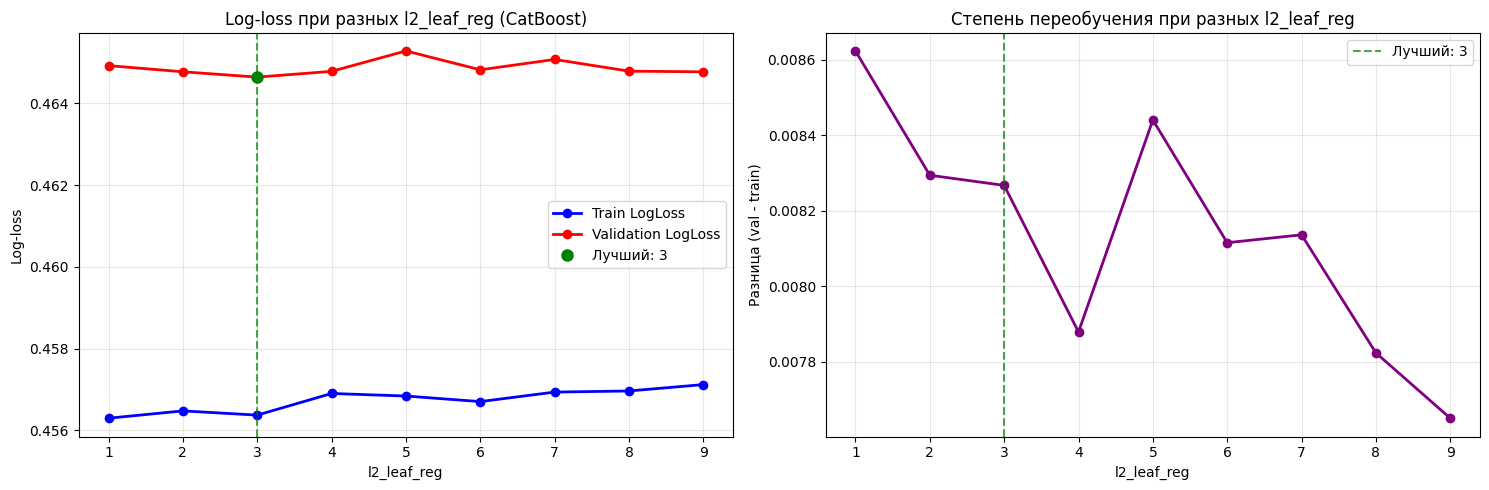


Лучший l2_leaf_reg: 3
Log-loss на валидации: 0.4646


In [58]:
original_params = {
    "iterations": 350,
    "learning_rate": 0.01,
    "depth": 5,
    "subsample": 0.8,
    "random_state": 42,
    "verbose": False
}

l2_leaf_reg_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_logloss = []
val_logloss = []

#Перебор l2_leaf_reg
for l2_reg in l2_leaf_reg_values:
    params = dict(original_params)
    params["l2_leaf_reg"] = l2_reg
    clf = CatBoostClassifier(**params)
    clf.fit(X_tr_enc, y_tr, eval_set=(X_val_enc, y_val), verbose=False)

    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация Log-loss
axes[0].plot(l2_leaf_reg_values, train_logloss, label="Train LogLoss", color="blue", marker="o", linewidth=2)
axes[0].plot(l2_leaf_reg_values, val_logloss, label="Validation LogLoss", color="red", marker="o", linewidth=2)
axes[0].set_xlabel("l2_leaf_reg")
axes[0].set_ylabel("Log-loss")
axes[0].legend(loc='best')
axes[0].set_title("Log-loss при разных l2_leaf_reg (CatBoost)")
axes[0].grid(True, alpha=0.3)

#Разница между train и validation
overfitting_gap = [val - train for val, train in zip(val_logloss, train_logloss)]
axes[1].plot(l2_leaf_reg_values, overfitting_gap, color="purple", marker="o", linewidth=2)
axes[1].set_xlabel("l2_leaf_reg")
axes[1].set_ylabel("Разница (val - train)")
axes[1].set_title("Степень переобучения при разных l2_leaf_reg")
axes[1].grid(True, alpha=0.3)

best_idx = np.argmin(val_logloss)
best_l2_reg = l2_leaf_reg_values[best_idx]
best_val_loss = val_logloss[best_idx]

axes[0].axvline(x=best_l2_reg, color='green', linestyle='--', alpha=0.7)
axes[0].plot(best_l2_reg, best_val_loss, 'go', markersize=8, label=f'Лучший: {best_l2_reg}')
axes[0].legend()

axes[1].axvline(x=best_l2_reg, color='green', linestyle='--', alpha=0.7, label=f'Лучший: {best_l2_reg}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nЛучший l2_leaf_reg: {best_l2_reg}")
print(f"Log-loss на валидации: {best_val_loss:.4f}")

##### с калибровкой

In [60]:
model = CatBoostClassifier(
    iterations=350,
    learning_rate=0.01,
    depth=5,
    subsample=0.8,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False
)
model.fit(X_tr_enc, y_tr)

#логлосс ДО
y_pred_base = model.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка 
calibrated = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
calibrated.fit(X_val_enc, y_val)

#логлосс ПОСЛЕ 
y_pred_cal = calibrated.predict_proba(X_val_enc)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.464641
Log-loss после калибровки: 0.459507


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### NN

In [21]:
#X_tr_enc = CT.fit_transform(X_tr)
#X_val_enc = CT.transform(X_val)

In [62]:
class RewardNet(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, dropout=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x)

#Обучение и вывод логлосса
def train_reward_nn(X_tr_enc, y_tr, X_val_enc, y_val,
                    lr=1e-5, batch_size=64, n_epochs=50, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #преобразуем в numpy 
    X_tr = np.asarray(X_tr_enc, dtype=np.float32)
    X_val = np.asarray(X_val_enc, dtype=np.float32)
    y_tr = np.asarray(y_tr, dtype=np.float32).reshape(-1, 1)
    y_val = np.asarray(y_val, dtype=np.float32).reshape(-1, 1)

    #DataLoaders
    train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
    val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = RewardNet(X_tr.shape[1]).to(device)

    #Считаем pos_weight для баланса классов
    pos_weight = torch.tensor([(len(y_tr) - y_tr.sum()) / y_tr.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    best_val_loss = np.inf
    no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(xb)

        #Валидация
        model.eval()
        val_logits, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.to(device)
                out = model(xb)
                val_logits.append(out.cpu().numpy())
                val_targets.append(yb.numpy())

        val_logits = np.vstack(val_logits).ravel()
        val_targets = np.vstack(val_targets).ravel()

        val_probs = 1 / (1 + np.exp(-val_logits))
        val_logloss = log_loss(val_targets, val_probs)
        train_loss /= len(X_tr)

        print(f"Epoch {epoch:03d}: train_loss={train_loss:.5f}, val_logloss={val_logloss:.5f}")

        if val_logloss < best_val_loss - 1e-6:
            best_val_loss = val_logloss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping! Best val_logloss = {best_val_loss:.6f}")
                break

    print(f"\nФинальный log-loss на валидации: {best_val_loss:.6f}")

In [64]:
train_reward_nn(X_tr_enc, y_tr, X_val_enc, y_val)

Epoch 001: train_loss=1.14995, val_logloss=0.73974
Epoch 002: train_loss=1.14667, val_logloss=0.73776
Epoch 003: train_loss=1.13703, val_logloss=0.73749
Epoch 004: train_loss=1.13506, val_logloss=0.72804
Epoch 005: train_loss=1.12849, val_logloss=0.72605
Epoch 006: train_loss=1.12744, val_logloss=0.72336
Epoch 007: train_loss=1.12858, val_logloss=0.71226
Epoch 008: train_loss=1.11833, val_logloss=0.71271
Epoch 009: train_loss=1.12226, val_logloss=0.71273
Epoch 010: train_loss=1.12455, val_logloss=0.70527
Epoch 011: train_loss=1.12120, val_logloss=0.70947
Epoch 012: train_loss=1.11549, val_logloss=0.70017
Epoch 013: train_loss=1.11471, val_logloss=0.70854
Epoch 014: train_loss=1.11439, val_logloss=0.70101
Epoch 015: train_loss=1.11271, val_logloss=0.69619
Epoch 016: train_loss=1.11125, val_logloss=0.69746
Epoch 017: train_loss=1.11191, val_logloss=0.69762
Epoch 018: train_loss=1.11192, val_logloss=0.69638
Epoch 019: train_loss=1.10980, val_logloss=0.69434
Epoch 020: train_loss=1.11177, 

#### Voting

In [66]:
base_model_lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000)
base_model_lr.fit(X_tr_enc, y_tr)
y_pred_base = base_model_lr.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss logreg: {logloss_before:.6f}")

base_model_cb = CatBoostClassifier(
    iterations=350,
    learning_rate=0.01,
    depth=5,
    subsample=0.8,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False)
base_model_cb.fit(X_tr_enc, y_tr)
y_pred_base = base_model_cb.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss catboost: {logloss_before:.6f}")


base_model_rf = RandomForestClassifier(n_estimators=350, oob_score = True, max_depth = 6, min_samples_leaf=17,
                                  max_features="sqrt", min_samples_split = 2, n_jobs=-1)
base_model_rf.fit(X_tr_enc, y_tr)
y_pred_base = base_model_rf.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss randomforest: {logloss_before:.6f}")

Log-loss logreg: 0.465185
Log-loss catboost: 0.464641
Log-loss randomforest: 0.465363


In [68]:
voting = VotingClassifier(
    estimators=[
        ('lr', base_model_lr),
        ('rf', base_model_rf),
        ('cb', base_model_cb)
    ],
    voting='soft'
)
voting.fit(X_tr_enc, y_tr)

print("Log-loss voting (before calib):", log_loss(y_val, voting.predict_proba(X_val_enc)))

# 3) калибруем уже готовый ансамбль
calibrated_voting = CalibratedClassifierCV(voting, cv='prefit', method='isotonic')
calibrated_voting.fit(X_val_enc, y_val)

print("Log-loss voting (after calib):", log_loss(y_val, calibrated_voting.predict_proba(X_val_enc)))


Log-loss voting (before calib): 0.4646294028624557
Log-loss voting (after calib): 0.4601538209185037


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Stacking

In [70]:
#Базовые модели
base_model_lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000)

base_model_cb = CatBoostClassifier(
    iterations=350,
    learning_rate=0.01,
    depth=5,
    subsample=0.8,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False)

base_model_rf = RandomForestClassifier(n_estimators=350, oob_score = True, max_depth = 6, min_samples_leaf=17,
                                  max_features="sqrt", min_samples_split = 2, n_jobs=-1)

#Мета-модель
meta_model = LogisticRegression(max_iter=5000)

#Стекинг
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', base_model_lr),
        ('rf', base_model_rf),
        ('cb', base_model_cb)
    ],
    final_estimator=meta_model,
    stack_method='predict_proba',  
    passthrough=False,             
    cv=5,                          
    n_jobs=-1
)


stacking_clf.fit(X_tr_enc, y_tr)
val_proba = stacking_clf.predict_proba(X_val_enc)[:, 1]
print(f"Log-loss стекинга: {log_loss(y_val, val_proba):.6f}")

Log-loss стекинга: 0.465134


In [72]:
calibrated_stacking = CalibratedClassifierCV(stacking_clf, cv='prefit', method='isotonic')
calibrated_stacking.fit(X_val_enc, y_val)

print("Log-loss voting (after calib):", log_loss(y_val, calibrated_stacking.predict_proba(X_val_enc)))

Log-loss voting (after calib): 0.45970184222584637


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


### 2-ая reward модель: Womens E-Mail

In [74]:
X_tr, X_val, y_tr, y_val = train_test_split(train_womens, y_womens, test_size = 0.2, stratify = y_womens)

#### Логистическая регрессия

In [76]:
pipe = Pipeline(steps=[
    ('preprocessor', CT),
    ('classifier', LogisticRegression(max_iter=10000))
])

param_grid = [
    {
        'classifier__penalty': ['l2'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier__penalty': ['l1'],
        'classifier__solver': ['liblinear'],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier__penalty': [None],
        'classifier__solver': ['lbfgs', 'newton-cg']
    }
]

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, train_size=0.75, random_state=42)


grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='neg_log_loss',   
    return_train_score=True
)

grid.fit(X_tr, y_tr)

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средний log loss на CV: {:.6f}".format(-grid.best_score_))

y_pred_proba = grid.predict_proba(X_val)
print("Log loss на валидации: {:.6f}".format(log_loss(y_val, y_pred_proba)))

grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score", "std_test_score"]).T
grid_result

----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Средний log loss на CV: 0.413654
Log loss на валидации: 0.414255


,26,7,27,9,5,8,6,12,11,14,...,21,30,20,31,1,4,3,0,2,25
mean_fit_time,0.048025,0.014501,0.15821,0.197383,0.018875,0.10032,0.018262,0.021187,0.017834,0.727064,...,0.019319,0.018488,0.01795,0.016201,0.015671,0.057481,0.023982,0.023809,0.015875,0.017044
std_fit_time,0.003904,0.002236,0.055352,0.012389,0.00219,0.011306,0.001911,0.001706,0.001549,0.023741,...,0.00125,0.00119,0.002554,0.002245,0.002415,0.006001,0.003853,0.014353,0.005208,0.003289
mean_score_time,0.005525,0.004336,0.004867,0.005483,0.004585,0.004794,0.003989,0.00461,0.003727,0.003389,...,0.003447,0.003712,0.004645,0.005019,0.003029,0.003924,0.005198,0.004932,0.003307,0.004234
std_score_time,0.002155,0.001281,0.002463,0.002597,0.002043,0.00228,0.001382,0.001407,0.000969,0.000193,...,0.000688,0.00171,0.001566,0.002365,0.000056,0.001832,0.002182,0.001851,0.000583,0.000969
param_classifier__C,0.1,0.1,1.0,0.1,0.1,0.1,0.1,1.0,1.0,1.0,...,100.0,NaN,100.0,NaN,0.01,0.01,0.01,0.01,0.01,0.01
param_classifier__penalty,l1,l2,l1,l2,l2,l2,l2,l2,l2,l2,...,l2,None,l2,None,l2,l2,l2,l2,l2,l1
param_classifier__solver,liblinear,liblinear,liblinear,saga,newton-cg,sag,lbfgs,liblinear,lbfgs,saga,...,lbfgs,lbfgs,newton-cg,newton-cg,lbfgs,saga,sag,newton-cg,liblinear,liblinear
params,"{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 1, 'classifier__penalty': 'l...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 1, 'classifier__penalty': 'l...","{'classifier__C': 1, 'classifier__penalty': 'l...","{'classifier__C': 1, 'classifier__penalty': 'l...",...,"{'classifier__C': 100, 'classifier__penalty': ...","{'classifier__penalty': None, 'classifier__sol...","{'classifier__C': 100, 'classifier__penalty': ...","{'classifier__penalty': None, 'classifier__sol...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':..."
split0_test_score,-0.417935,-0.418319,-0.418249,-0.418339,-0.418338,-0.418339,-0.418334,-0.418351,-0.418355,-0.418379,...,-0.418399,-0.4184,-0.418406,-0.418406,-0.418318,-0.418315,-0.418315,-0.418315,-0.418712,-0.420907
split1_test_score,-0.414545,-0.41427,-0.414412,-0.414384,-0.414384,-0.414384,-0.414379,-0.414388,-0.414431,-0.414461,...,-0.41453,-0.414527,-0.414537,-0.414538,-0.414862,-0.414877,-0.414878,-0.414879,-0.415343,-0.420412


##### Логрег с калибровкой

In [78]:
base_model = Pipeline(steps=[
    ('preprocessor', CT),
    ('classifier', LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=10000))
])
base_model.fit(X_tr, y_tr)

#логлосс ДО калибровки
y_pred_base = base_model.predict_proba(X_val)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val, y_val)

#логлосс ПОСЛЕ 
y_pred_cal = calibrated.predict_proba(X_val)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.414255
Log-loss после калибровки: 0.409325


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Градиентный бустинг


 Обучаем модель с learning_rate=0.05


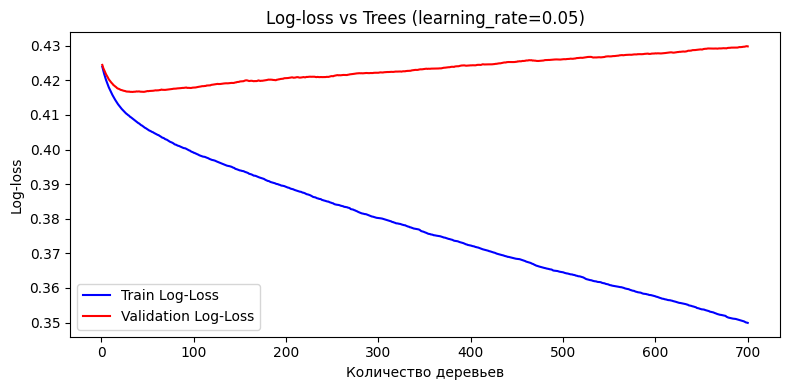

Log-loss на валидации (0.05): 0.429831

 Обучаем модель с learning_rate=0.01


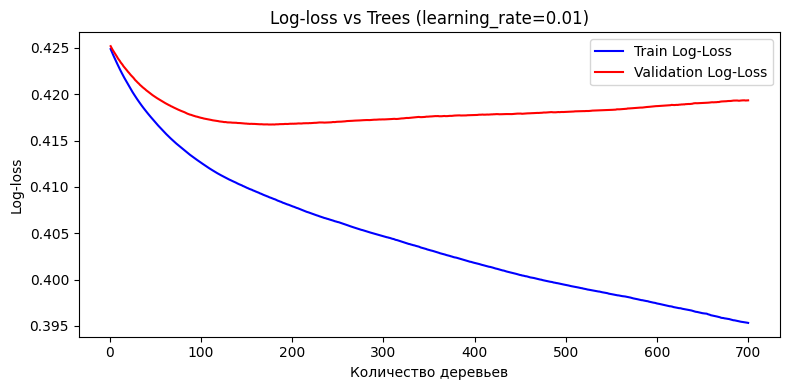

Log-loss на валидации (0.01): 0.419341

 Обучаем модель с learning_rate=0.001


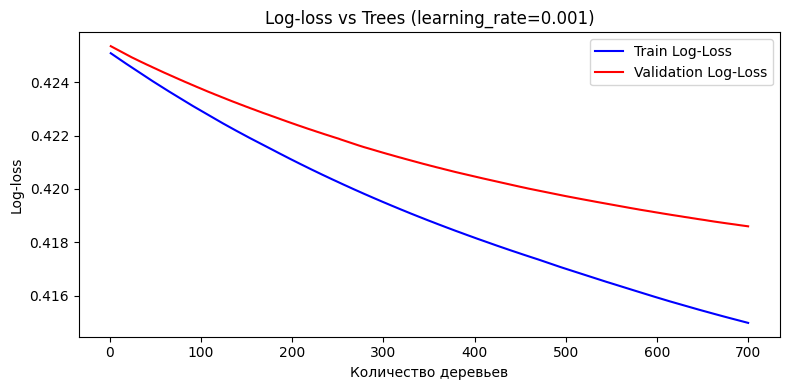

Log-loss на валидации (0.001): 0.418597


In [80]:
X_tr_enc = CT.fit_transform(X_tr)
X_val_enc = CT.transform(X_val)

#Функция для построения log-loss
def plot_learning_tree_logloss(estimator, X_tr, X_val, y_tr, y_val, learning_rate=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    n_estimators = estimator.n_estimators_
    zero = np.zeros(n_estimators, dtype=np.float64)

    #на train
    train_loss = zero.copy()
    for i, y_pred_train in enumerate(estimator.staged_predict_proba(X_tr)):
        train_loss[i] = log_loss(y_tr, y_pred_train)

    #на validation
    val_loss = zero.copy()
    for i, y_pred_val in enumerate(estimator.staged_predict_proba(X_val)):
        val_loss[i] = log_loss(y_val, y_pred_val)

    ax.plot(np.arange(1, n_estimators + 1), train_loss, '-', color='blue', label='Train Log-Loss')
    ax.plot(np.arange(1, n_estimators + 1), val_loss, '-', color='red', label='Validation Log-Loss')

    ax.legend(loc='best')
    ax.set_title(f'Log-loss vs Trees (learning_rate={learning_rate})')
    ax.set_xlabel('Количество деревьев')
    ax.set_ylabel('Log-loss')
    plt.tight_layout()
    plt.show()

#Обучаем модели с разными learning_rate
for lr in [0.05, 0.01, 0.001]:
    print(f"\n Обучаем модель с learning_rate={lr}")
    clf = GradientBoostingClassifier(
        n_estimators=700,
        learning_rate=lr,
        random_state=42
    )
    clf.fit(X_tr_enc, y_tr)

    
    plot_learning_tree_logloss(clf, X_tr_enc, X_val_enc, y_tr, y_val, learning_rate=lr)

    y_pred_val = clf.predict_proba(X_val_enc)
    print(f"Log-loss на валидации ({lr}): {log_loss(y_val, y_pred_val):.6f}")

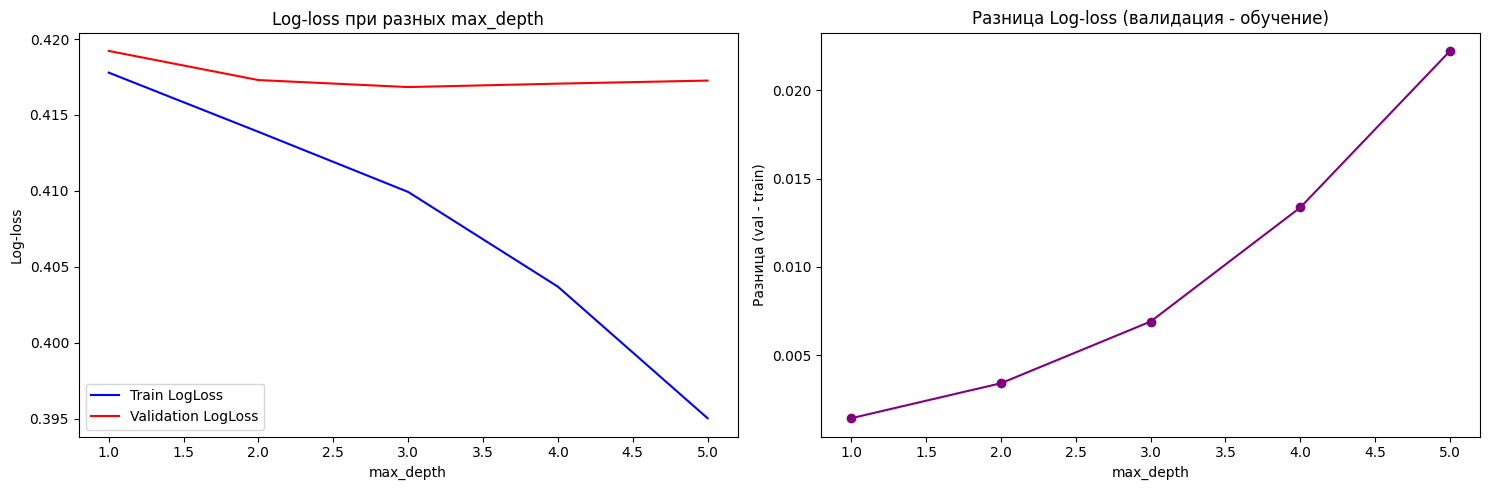

In [82]:
original_params = {
    "n_estimators": 150,
    "learning_rate": 0.01,
    "random_state": 42
}

max_depths = range(1, 6)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_logloss = []
val_logloss = []

#Перебор max_depth 
for depth in max_depths:
    params = dict(original_params)
    params["max_depth"] = depth
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_tr_enc, y_tr)

    # Log-loss
    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация
axes[0].plot(max_depths, train_logloss, label="Train LogLoss", color="blue")
axes[0].plot(max_depths, val_logloss, label="Validation LogLoss", color="red")
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("Log-loss")
axes[0].legend()
axes[0].set_title("Log-loss при разных max_depth")

#разница train-val 
axes[1].plot(max_depths, [v - t for v, t in zip(val_logloss, train_logloss)], 
             color="purple", marker='o')
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("Разница (val - train)")
axes[1].set_title("Разница Log-loss (валидация - обучение)")

plt.tight_layout()
plt.show()

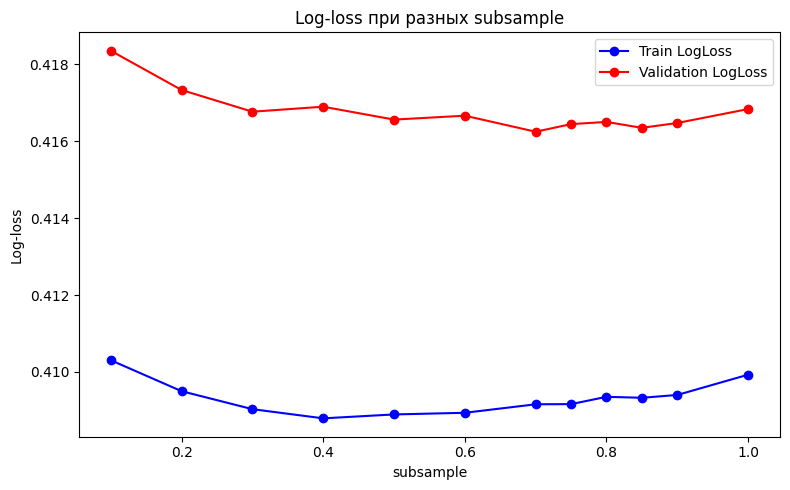

In [84]:
original_params = {
    "n_estimators": 150,
    "learning_rate": 0.01,
    "max_depth": 3,
    "random_state": 42
}

subsamples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

fig, ax = plt.subplots(figsize=(8, 5))

train_logloss = []
val_logloss = []

#Перебор subsample
for subsample_val in subsamples:
    params = dict(original_params)
    params["subsample"] = subsample_val
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_tr_enc, y_tr)

    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация
ax.plot(subsamples, train_logloss, label="Train LogLoss", color="blue", marker="o")
ax.plot(subsamples, val_logloss, label="Validation LogLoss", color="red", marker="o")
ax.set_xlabel("subsample")
ax.set_ylabel("Log-loss")
ax.legend(loc='best')
ax.set_title("Log-loss при разных subsample")

plt.tight_layout()
plt.show()

##### с калибровкой

In [86]:
base_model = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.01, max_depth = 3, subsample = 0.7)
base_model.fit(X_tr_enc, y_tr)

#логлосс ДО
y_pred_base = base_model.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка модели
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val_enc, y_val)

#логлосс ПОСЛЕ
y_pred_cal = calibrated.predict_proba(X_val_enc)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.416552
Log-loss после калибровки: 0.412291


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### RandomForest

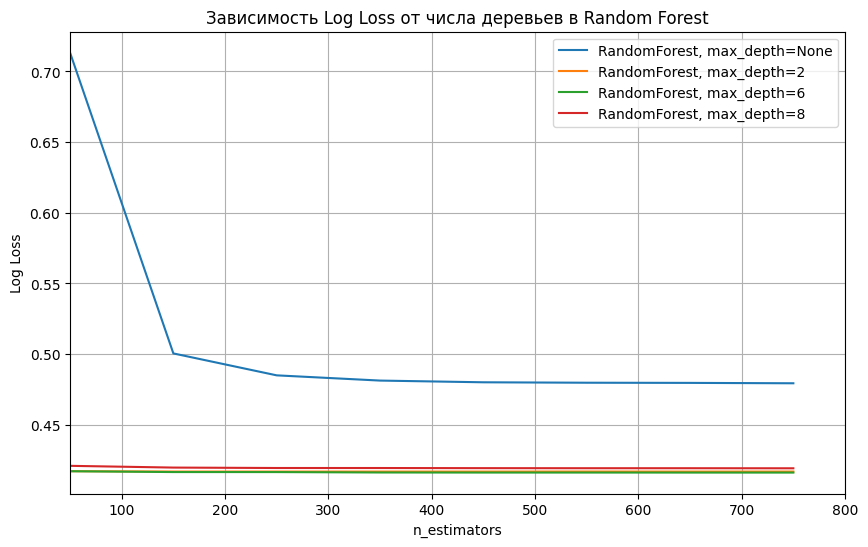

In [88]:
RANDOM_STATE = 42 

#Разные глубины деревьев
ensemble_clfs = [
    ("RandomForest, max_depth=None", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=None,
    )),
    ("RandomForest, max_depth=2", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=2,
    )),
    ("RandomForest, max_depth=6", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=6,
    )),
    ("RandomForest, max_depth=8", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=8,
    )),
]

#Хранилище результатов
logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)
        y_pred_proba = clf.predict_proba(X_val_enc)
        score = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, score))

#Визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.title("Зависимость Log Loss от числа деревьев в Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.show()

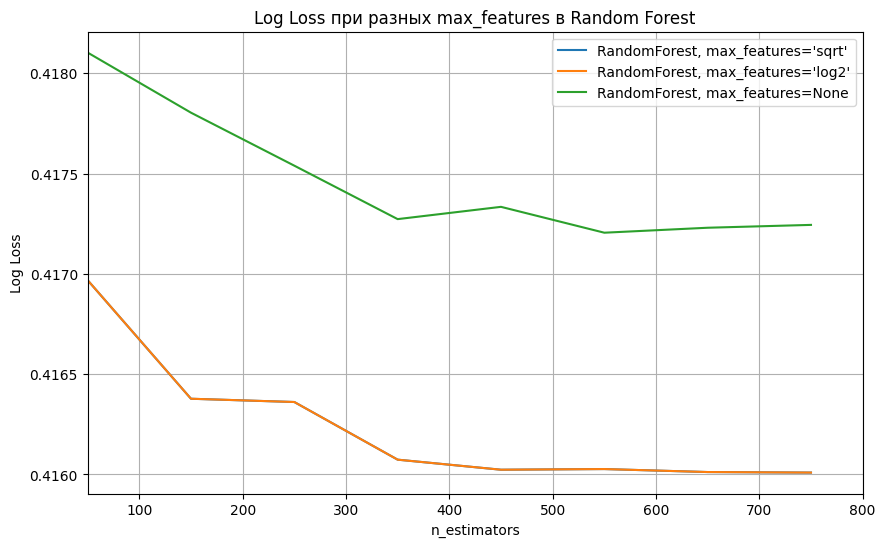

In [96]:
ensemble_clfs = [
    (
        "RandomForest, max_features='sqrt'",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, max_features='log2'",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="log2",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, max_features=None",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features=None,
            random_state=RANDOM_STATE,
        ),
    ),
]

logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)

        y_pred_proba = clf.predict_proba(X_val_enc)
        logloss = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, logloss))

#Визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.legend(loc="best")
plt.title("Log Loss при разных max_features в Random Forest")
plt.grid(True)
plt.show()

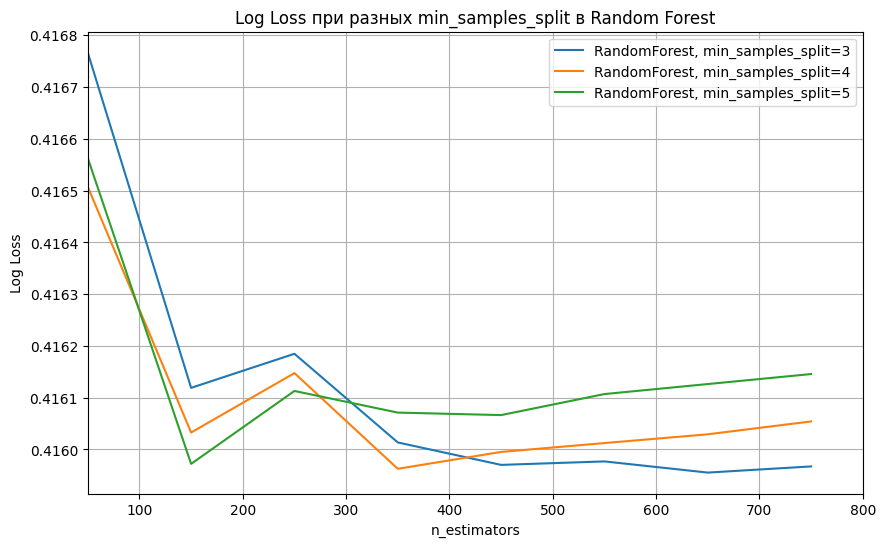

In [100]:
ensemble_clfs = [
    (
        "RandomForest, min_samples_split=3",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=3,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_split=4",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=4,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_split=5",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=5,
            random_state=RANDOM_STATE,
        ),
    ),
]

logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)

        y_pred_proba = clf.predict_proba(X_val_enc)
        loss = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, loss))

#Визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.title("Log Loss при разных min_samples_split в Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.show()

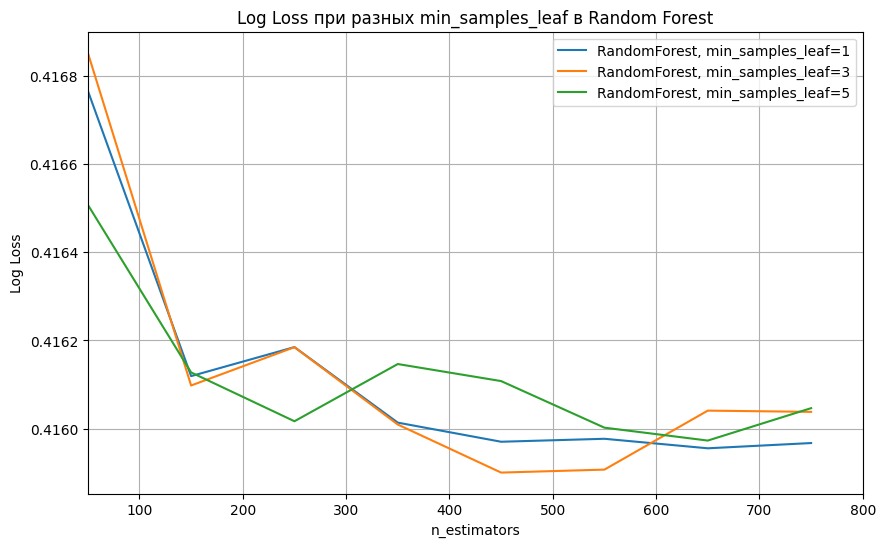

In [102]:
ensemble_clfs = [
    (
        "RandomForest, min_samples_leaf=1",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=3,
            min_samples_leaf=1,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_leaf=3",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=3,
            min_samples_leaf=3,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_leaf=5",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            min_samples_split=3,
            min_samples_leaf=5,
            random_state=RANDOM_STATE,
        ),
    ),
]

logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)

        y_pred_proba = clf.predict_proba(X_val_enc)
        loss = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, loss))

# визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.title("Log Loss при разных min_samples_leaf в Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.show()

##### с калибровкой

In [104]:
base_model = RandomForestClassifier(n_estimators=500, oob_score = True, max_depth = 6, min_samples_leaf=3,
                                  max_features='sqrt', min_samples_split = 3, n_jobs=-1)
base_model.fit(X_tr_enc, y_tr)

#логлосс ДО
y_pred_base = base_model.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка 
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val_enc, y_val)

#логлосс ПОСЛЕ 
y_pred_cal = calibrated.predict_proba(X_val_enc)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.416231
Log-loss после калибровки: 0.411478


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Catboost


 Обучаем модель с learning_rate=0.005
0:	learn: 0.6899785	test: 0.6899887	best: 0.6899887 (0)	total: 7.52ms	remaining: 7.51s
100:	learn: 0.5017239	test: 0.5026337	best: 0.5026337 (100)	total: 201ms	remaining: 1.78s
200:	learn: 0.4410714	test: 0.4436196	best: 0.4436196 (200)	total: 389ms	remaining: 1.55s
300:	learn: 0.4198022	test: 0.4242708	best: 0.4242708 (300)	total: 578ms	remaining: 1.34s
400:	learn: 0.4112299	test: 0.4177784	best: 0.4177784 (400)	total: 772ms	remaining: 1.15s
500:	learn: 0.4068584	test: 0.4156102	best: 0.4156102 (500)	total: 969ms	remaining: 965ms
600:	learn: 0.4041893	test: 0.4149110	best: 0.4149110 (600)	total: 1.17s	remaining: 774ms
700:	learn: 0.4017849	test: 0.4146629	best: 0.4146424 (681)	total: 1.37s	remaining: 583ms
800:	learn: 0.3997295	test: 0.4148093	best: 0.4146424 (681)	total: 1.56s	remaining: 389ms
900:	learn: 0.3979888	test: 0.4150030	best: 0.4146424 (681)	total: 1.76s	remaining: 194ms
999:	learn: 0.3962898	test: 0.4152157	best: 0.4146424 (681)	tota

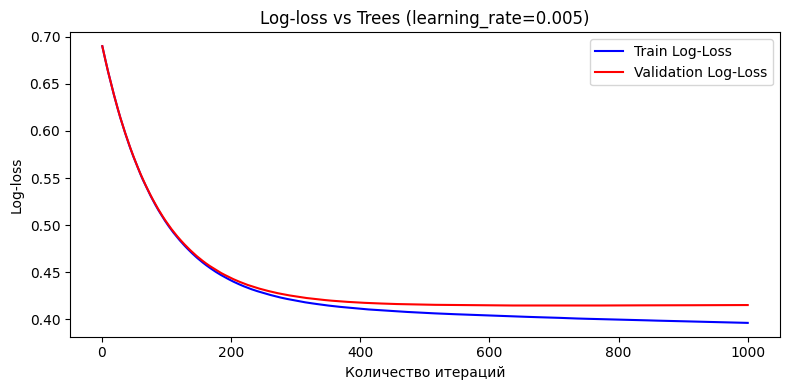

Log-loss на валидации (0.005): 0.414642
Лучшая итерация: 681

 Обучаем модель с learning_rate=0.01
0:	learn: 0.6868301	test: 0.6868510	best: 0.6868510 (0)	total: 2.97ms	remaining: 2.97s
100:	learn: 0.4404995	test: 0.4432748	best: 0.4432748 (100)	total: 242ms	remaining: 2.16s
200:	learn: 0.4108594	test: 0.4175417	best: 0.4175417 (200)	total: 435ms	remaining: 1.73s
300:	learn: 0.4036787	test: 0.4150276	best: 0.4150190 (298)	total: 631ms	remaining: 1.47s
400:	learn: 0.3995005	test: 0.4151199	best: 0.4148649 (341)	total: 828ms	remaining: 1.24s
500:	learn: 0.3958021	test: 0.4156822	best: 0.4148649 (341)	total: 1.03s	remaining: 1.02s
600:	learn: 0.3924817	test: 0.4161263	best: 0.4148649 (341)	total: 1.23s	remaining: 814ms
700:	learn: 0.3894093	test: 0.4167093	best: 0.4148649 (341)	total: 1.42s	remaining: 607ms
800:	learn: 0.3865079	test: 0.4173691	best: 0.4148649 (341)	total: 1.62s	remaining: 402ms
900:	learn: 0.3834262	test: 0.4178165	best: 0.4148649 (341)	total: 1.82s	remaining: 200ms
999:

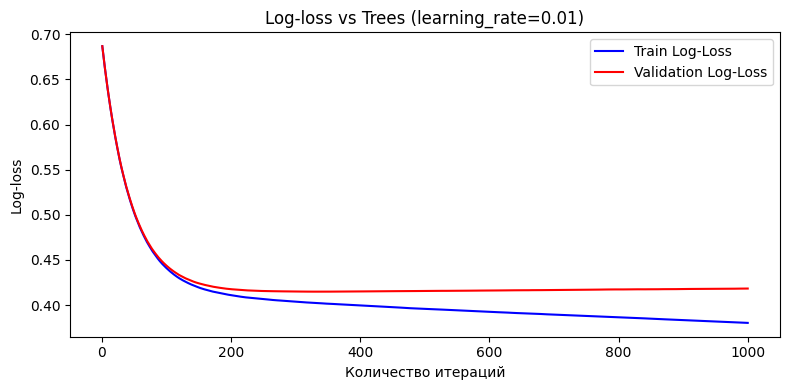

Log-loss на валидации (0.01): 0.414865
Лучшая итерация: 341

 Обучаем модель с learning_rate=0.05
0:	learn: 0.6624031	test: 0.6624931	best: 0.6624931 (0)	total: 4.48ms	remaining: 4.48s
100:	learn: 0.3971965	test: 0.4148760	best: 0.4144938 (80)	total: 269ms	remaining: 2.4s
200:	learn: 0.3810894	test: 0.4182953	best: 0.4144938 (80)	total: 473ms	remaining: 1.88s
300:	learn: 0.3654300	test: 0.4213938	best: 0.4144938 (80)	total: 671ms	remaining: 1.56s
400:	learn: 0.3503902	test: 0.4249956	best: 0.4144938 (80)	total: 872ms	remaining: 1.3s
500:	learn: 0.3370566	test: 0.4279311	best: 0.4144938 (80)	total: 1.07s	remaining: 1.06s
600:	learn: 0.3254317	test: 0.4303002	best: 0.4144938 (80)	total: 1.27s	remaining: 843ms
700:	learn: 0.3136879	test: 0.4330918	best: 0.4144938 (80)	total: 1.47s	remaining: 627ms
800:	learn: 0.3030046	test: 0.4354974	best: 0.4144938 (80)	total: 1.67s	remaining: 414ms
900:	learn: 0.2925210	test: 0.4377045	best: 0.4144938 (80)	total: 1.89s	remaining: 207ms
999:	learn: 0.28

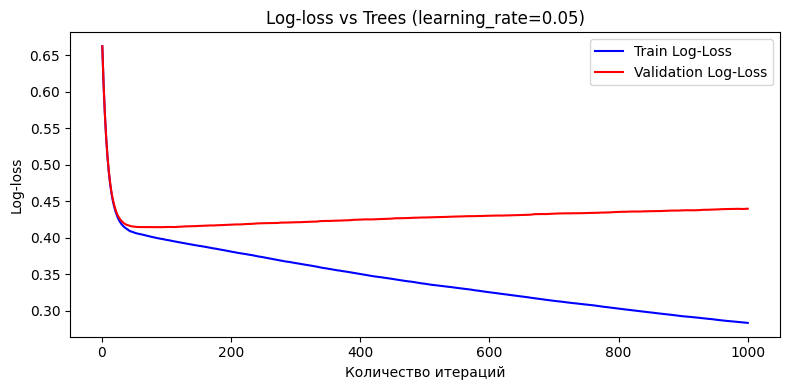

Log-loss на валидации (0.05): 0.414494
Лучшая итерация: 80

 Обучаем модель с learning_rate=0.1
0:	learn: 0.6337315	test: 0.6339015	best: 0.6339015 (0)	total: 3.41ms	remaining: 3.41s
100:	learn: 0.3811596	test: 0.4181607	best: 0.4154213 (30)	total: 261ms	remaining: 2.33s
200:	learn: 0.3505808	test: 0.4248003	best: 0.4154213 (30)	total: 460ms	remaining: 1.83s
300:	learn: 0.3255312	test: 0.4307922	best: 0.4154213 (30)	total: 658ms	remaining: 1.53s
400:	learn: 0.3027696	test: 0.4365993	best: 0.4154213 (30)	total: 855ms	remaining: 1.28s
500:	learn: 0.2835116	test: 0.4430712	best: 0.4154213 (30)	total: 1.05s	remaining: 1.05s
600:	learn: 0.2668507	test: 0.4463494	best: 0.4154213 (30)	total: 1.25s	remaining: 832ms
700:	learn: 0.2513181	test: 0.4502266	best: 0.4154213 (30)	total: 1.45s	remaining: 620ms
800:	learn: 0.2365481	test: 0.4560045	best: 0.4154213 (30)	total: 1.66s	remaining: 412ms
900:	learn: 0.2237343	test: 0.4604662	best: 0.4154213 (30)	total: 1.87s	remaining: 205ms
999:	learn: 0.21

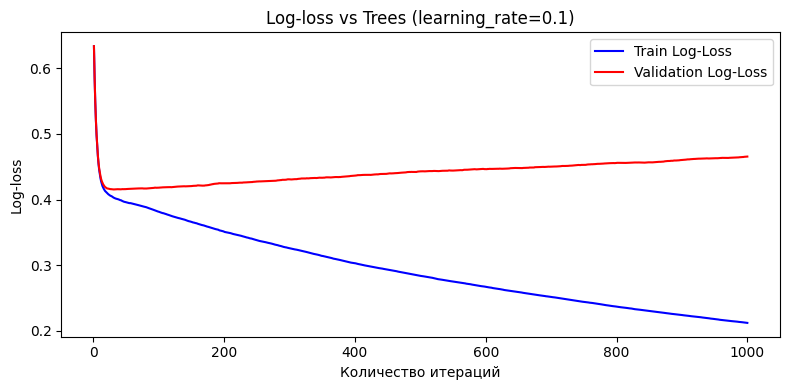

Log-loss на валидации (0.1): 0.415421
Лучшая итерация: 30


In [106]:
def plot_catboost_learning_curve(estimator, learning_rate=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    evals_result = estimator.get_evals_result()
    
    if 'learn' in evals_result and 'validation' in evals_result:
        train_loss = evals_result['learn']['Logloss']
        val_loss = evals_result['validation']['Logloss']
        
        ax.plot(np.arange(1, len(train_loss) + 1), train_loss, '-', color='blue', label='Train Log-Loss')
        ax.plot(np.arange(1, len(val_loss) + 1), val_loss, '-', color='red', label='Validation Log-Loss')
        
        ax.legend(loc='best')
        ax.set_title(f'Log-loss vs Trees (learning_rate={learning_rate})')
        ax.set_xlabel('Количество итераций')
        ax.set_ylabel('Log-loss')
        plt.tight_layout()
        plt.show()
    else:
        print("История обучения недоступна")

# Обучаем модели
for lr in [0.005, 0.01, 0.05, 0.1]:
    print(f"\n Обучаем модель с learning_rate={lr}")
    clf = CatBoostClassifier(
        iterations=1000,
        learning_rate=lr,
        random_state=42,
        verbose=100,
        eval_metric='Logloss'
    )
    
    clf.fit(
        X_tr_enc, y_tr,
        eval_set=(X_val_enc, y_val),
        verbose=100
    )

    plot_catboost_learning_curve(clf, learning_rate=lr)
    
    y_pred_val = clf.predict_proba(X_val_enc)
    print(f"Log-loss на валидации ({lr}): {log_loss(y_val, y_pred_val):.6f}")
    print(f"Лучшая итерация: {clf.get_best_iteration()}")

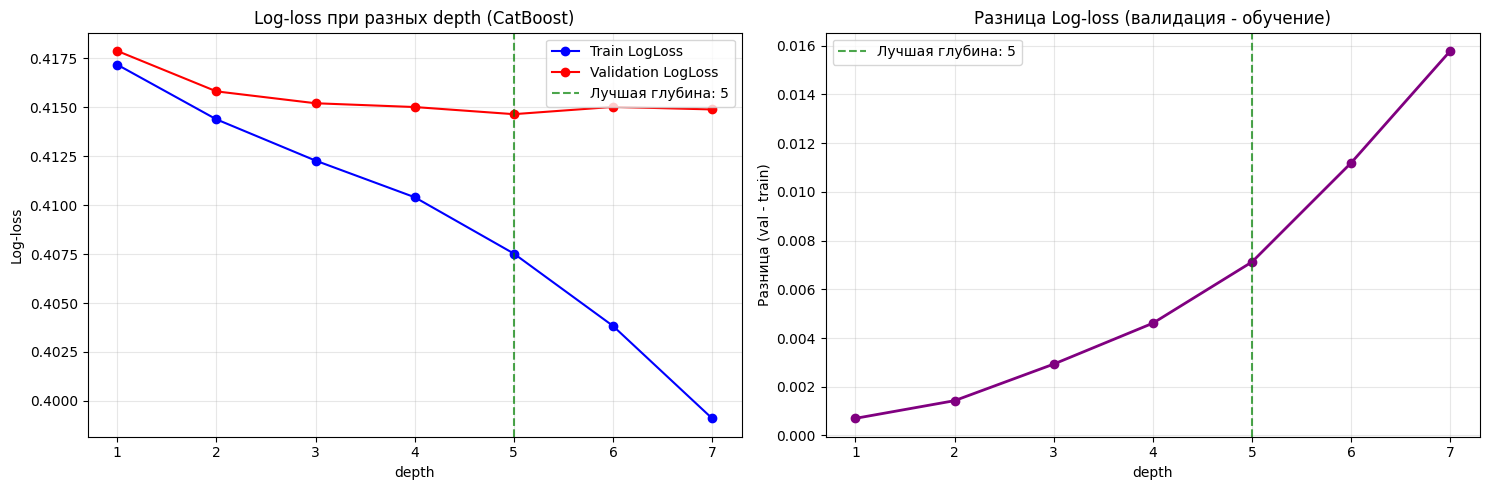


Лучшая глубина: 5
Лучший log-loss на валидации: 0.4146


In [112]:
original_params = {
    "iterations": 300,  
    "learning_rate": 0.01,
    "random_state": 42,
    "verbose": False  
}

max_depths = range(1, 8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_logloss = []
val_logloss = []

#Перебор max_depth 
for depth in max_depths:
    params = dict(original_params)
    params["depth"] = depth  
    
    clf = CatBoostClassifier(**params)
    clf.fit(X_tr_enc, y_tr, eval_set=(X_val_enc, y_val), verbose=False)

    # Log-loss
    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)
    

# Визуализация
axes[0].plot(max_depths, train_logloss, label="Train LogLoss", color="blue", marker='o')
axes[0].plot(max_depths, val_logloss, label="Validation LogLoss", color="red", marker='o')
axes[0].set_xlabel("depth")
axes[0].set_ylabel("Log-loss")
axes[0].legend()
axes[0].set_title("Log-loss при разных depth (CatBoost)")
axes[0].grid(True, alpha=0.3)

#Разница train-val 
axes[1].plot(max_depths, [v - t for v, t in zip(val_logloss, train_logloss)], 
             color="purple", marker='o', linewidth=2)
axes[1].set_xlabel("depth")
axes[1].set_ylabel("Разница (val - train)")
axes[1].set_title("Разница Log-loss (валидация - обучение)")
axes[1].grid(True, alpha=0.3)

best_depth_idx = np.argmin(val_logloss)
best_depth = max_depths[best_depth_idx]
axes[0].axvline(x=best_depth, color='green', linestyle='--', alpha=0.7, 
                label=f'Лучшая глубина: {best_depth}')
axes[0].legend()

axes[1].axvline(x=best_depth, color='green', linestyle='--', alpha=0.7,
                label=f'Лучшая глубина: {best_depth}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nЛучшая глубина: {best_depth}")
print(f"Лучший log-loss на валидации: {val_logloss[best_depth_idx]:.4f}")

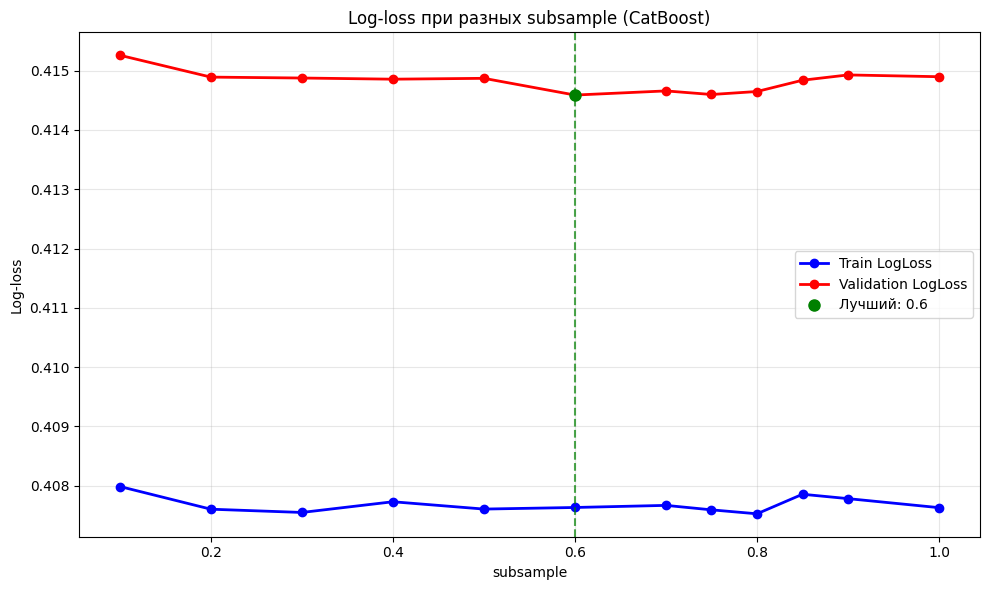


Лучший subsample: 0.6
Log-loss на валидации: 0.4146


In [114]:
original_params = {
    "iterations": 300,  
    "learning_rate": 0.01,
    "depth": 5,         
    "random_state": 42,
    "verbose": False    
}

subsamples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

fig, ax = plt.subplots(figsize=(10, 6))

train_logloss = []
val_logloss = []

#Перебор subsample
for subsample_val in subsamples:
    params = dict(original_params)
    params["subsample"] = subsample_val
    clf = CatBoostClassifier(**params)
    clf.fit(X_tr_enc, y_tr, eval_set=(X_val_enc, y_val), verbose=False)

    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация
ax.plot(subsamples, train_logloss, label="Train LogLoss", color="blue", marker="o", linewidth=2)
ax.plot(subsamples, val_logloss, label="Validation LogLoss", color="red", marker="o", linewidth=2)
ax.set_xlabel("subsample")
ax.set_ylabel("Log-loss")
ax.legend(loc='best')
ax.set_title("Log-loss при разных subsample (CatBoost)")
ax.grid(True, alpha=0.3)

best_idx = np.argmin(val_logloss)
best_subsample = subsamples[best_idx]
best_val_loss = val_logloss[best_idx]

ax.axvline(x=best_subsample, color='green', linestyle='--', alpha=0.7)
ax.plot(best_subsample, best_val_loss, 'go', markersize=8, label=f'Лучший: {best_subsample}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nЛучший subsample: {best_subsample}")
print(f"Log-loss на валидации: {best_val_loss:.4f}")

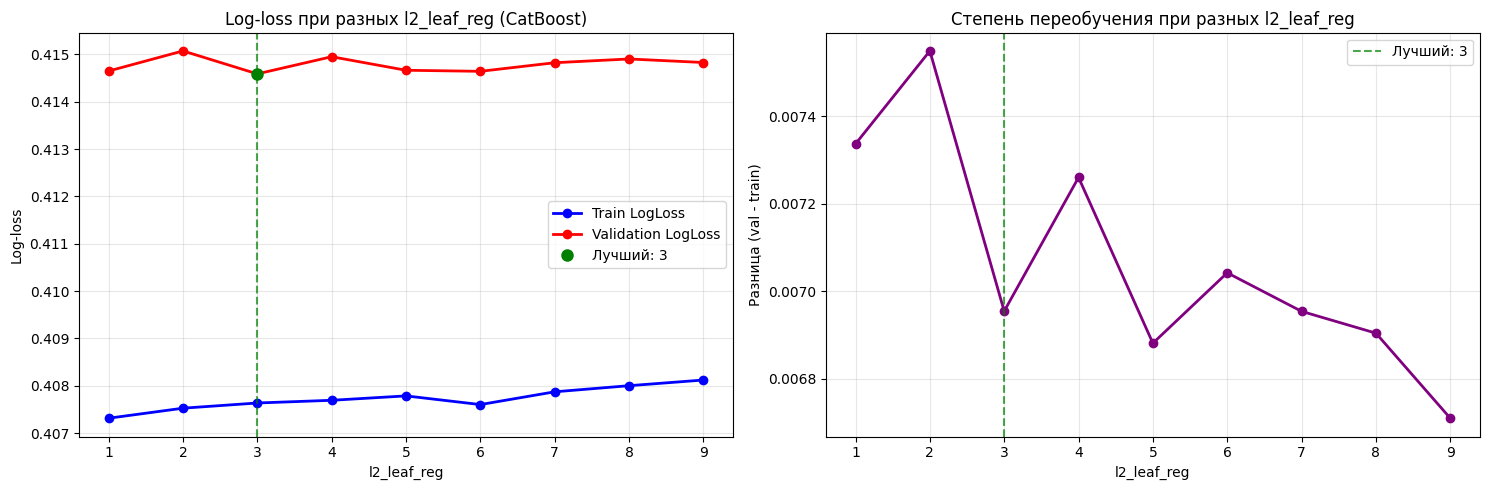


Лучший l2_leaf_reg: 3
Log-loss на валидации: 0.4146


In [116]:
original_params = {
    "iterations": 300,
    "learning_rate": 0.01,
    "depth": 5,
    "subsample": 0.6,
    "random_state": 42,
    "verbose": False
}

l2_leaf_reg_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_logloss = []
val_logloss = []

#Перебор l2_leaf_reg
for l2_reg in l2_leaf_reg_values:
    params = dict(original_params)
    params["l2_leaf_reg"] = l2_reg
    clf = CatBoostClassifier(**params)
    clf.fit(X_tr_enc, y_tr, eval_set=(X_val_enc, y_val), verbose=False)

    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация Log-loss
axes[0].plot(l2_leaf_reg_values, train_logloss, label="Train LogLoss", color="blue", marker="o", linewidth=2)
axes[0].plot(l2_leaf_reg_values, val_logloss, label="Validation LogLoss", color="red", marker="o", linewidth=2)
axes[0].set_xlabel("l2_leaf_reg")
axes[0].set_ylabel("Log-loss")
axes[0].legend(loc='best')
axes[0].set_title("Log-loss при разных l2_leaf_reg (CatBoost)")
axes[0].grid(True, alpha=0.3)

#Разница между train и validation
overfitting_gap = [val - train for val, train in zip(val_logloss, train_logloss)]
axes[1].plot(l2_leaf_reg_values, overfitting_gap, color="purple", marker="o", linewidth=2)
axes[1].set_xlabel("l2_leaf_reg")
axes[1].set_ylabel("Разница (val - train)")
axes[1].set_title("Степень переобучения при разных l2_leaf_reg")
axes[1].grid(True, alpha=0.3)

best_idx = np.argmin(val_logloss)
best_l2_reg = l2_leaf_reg_values[best_idx]
best_val_loss = val_logloss[best_idx]

axes[0].axvline(x=best_l2_reg, color='green', linestyle='--', alpha=0.7)
axes[0].plot(best_l2_reg, best_val_loss, 'go', markersize=8, label=f'Лучший: {best_l2_reg}')
axes[0].legend()

axes[1].axvline(x=best_l2_reg, color='green', linestyle='--', alpha=0.7, label=f'Лучший: {best_l2_reg}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nЛучший l2_leaf_reg: {best_l2_reg}")
print(f"Log-loss на валидации: {best_val_loss:.4f}")

##### С калибровкой

In [119]:
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.01,
    depth=5,
    subsample=0.6,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False
)
model.fit(X_tr_enc, y_tr)

#логлосс ДО
y_pred_base = model.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка 
calibrated = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
calibrated.fit(X_val_enc, y_val)

#логлосс ПОСЛЕ 
y_pred_cal = calibrated.predict_proba(X_val_enc)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.414589
Log-loss после калибровки: 0.409825


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### NN

In [121]:
class RewardNet(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, dropout=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x)

#Обучение и вывод логлосса
def train_reward_nn(X_tr_enc, y_tr, X_val_enc, y_val,
                    lr=1e-5, batch_size=64, n_epochs=50, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #преобразуем в numpy 
    X_tr = np.asarray(X_tr_enc, dtype=np.float32)
    X_val = np.asarray(X_val_enc, dtype=np.float32)
    y_tr = np.asarray(y_tr, dtype=np.float32).reshape(-1, 1)
    y_val = np.asarray(y_val, dtype=np.float32).reshape(-1, 1)

    #DataLoaders
    train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
    val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = RewardNet(X_tr.shape[1]).to(device)

    #Считаем pos_weight для баланса классов
    pos_weight = torch.tensor([(len(y_tr) - y_tr.sum()) / y_tr.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    best_val_loss = np.inf
    no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(xb)

        #Валидация
        model.eval()
        val_logits, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.to(device)
                out = model(xb)
                val_logits.append(out.cpu().numpy())
                val_targets.append(yb.numpy())

        val_logits = np.vstack(val_logits).ravel()
        val_targets = np.vstack(val_targets).ravel()

        val_probs = 1 / (1 + np.exp(-val_logits))
        val_logloss = log_loss(val_targets, val_probs)
        train_loss /= len(X_tr)

        print(f"Epoch {epoch:03d}: train_loss={train_loss:.5f}, val_logloss={val_logloss:.5f}")

        if val_logloss < best_val_loss - 1e-6:
            best_val_loss = val_logloss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping! Best val_logloss = {best_val_loss:.6f}")
                break

    print(f"\nФинальный log-loss на валидации: {best_val_loss:.6f}")

In [123]:
train_reward_nn(X_tr_enc, y_tr, X_val_enc, y_val)

Epoch 001: train_loss=1.21926, val_logloss=0.59435
Epoch 002: train_loss=1.21176, val_logloss=0.60228
Epoch 003: train_loss=1.19999, val_logloss=0.60413
Epoch 004: train_loss=1.19451, val_logloss=0.60492
Epoch 005: train_loss=1.18874, val_logloss=0.61465
Epoch 006: train_loss=1.18207, val_logloss=0.61300
Early stopping! Best val_logloss = 0.594346

Финальный log-loss на валидации: 0.594346


#### Voting

In [127]:
base_model_lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=10000)
base_model_lr.fit(X_tr_enc, y_tr)
y_pred_base = base_model_lr.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss logreg: {logloss_before:.6f}")

base_model_cb = CatBoostClassifier(
     iterations=300,
    learning_rate=0.01,
    depth=5,
    subsample=0.6,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False)
base_model_cb.fit(X_tr_enc, y_tr)
y_pred_base = base_model_cb.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss catboost: {logloss_before:.6f}")


base_model_rf = RandomForestClassifier(n_estimators=500, oob_score = True, max_depth = 6, min_samples_leaf=3,
                                  max_features='sqrt', min_samples_split = 3, n_jobs=-1)
base_model_rf.fit(X_tr_enc, y_tr)
y_pred_base = base_model_rf.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss randomforest: {logloss_before:.6f}")

Log-loss logreg: 0.414256
Log-loss catboost: 0.414589
Log-loss randomforest: 0.416173


In [128]:
voting = VotingClassifier(
    estimators=[
        ('lr', base_model_lr),
        ('rf', base_model_rf),
        ('cb', base_model_cb)
    ],
    voting='soft'
)
voting.fit(X_tr_enc, y_tr)

print("Log-loss voting (before calib):", log_loss(y_val, voting.predict_proba(X_val_enc)))

# 3) калибруем уже готовый ансамбль
calibrated_voting = CalibratedClassifierCV(voting, cv='prefit', method='isotonic')
calibrated_voting.fit(X_val_enc, y_val)

print("Log-loss voting (after calib):", log_loss(y_val, calibrated_voting.predict_proba(X_val_enc)))

Log-loss voting (before calib): 0.4144528250686633
Log-loss voting (after calib): 0.40967144207878914


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Stacking

In [131]:
#Базовые модели
base_model_lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=10000)

base_model_cb = CatBoostClassifier(
     iterations=300,
    learning_rate=0.01,
    depth=5,
    subsample=0.6,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False)

base_model_rf = RandomForestClassifier(n_estimators=500, oob_score = True, max_depth = 6, min_samples_leaf=3,
                                  max_features='sqrt', min_samples_split = 3, n_jobs=-1)

#Мета-модель
meta_model = LogisticRegression(max_iter=5000)

#Стекинг
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', base_model_lr),
        ('rf', base_model_rf),
        ('cb', base_model_cb)
    ],
    final_estimator=meta_model,
    stack_method='predict_proba',  
    passthrough=False,             
    cv=5,                          
    n_jobs=-1
)


stacking_clf.fit(X_tr_enc, y_tr)
val_proba = stacking_clf.predict_proba(X_val_enc)[:, 1]
print(f"Log-loss стекинга: {log_loss(y_val, val_proba):.6f}")

Log-loss стекинга: 0.415408


In [133]:
calibrated_stacking = CalibratedClassifierCV(stacking_clf, cv='prefit', method='isotonic')
calibrated_stacking.fit(X_val_enc, y_val)

print("Log-loss voting (after calib):", log_loss(y_val, calibrated_stacking.predict_proba(X_val_enc)))

Log-loss voting (after calib): 0.4096191984192099


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


### 3-ья reward модель: No E-Mail

In [137]:
X_tr, X_val, y_tr, y_val = train_test_split(train_none, y_none, test_size = 0.2, stratify = y_none)

#### Логистическая регрессия

In [139]:
pipe = Pipeline(steps=[
    ('preprocessor', CT),
    ('classifier', LogisticRegression(max_iter=10000))
])

param_grid = [
    {
        'classifier__penalty': ['l2'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier__penalty': ['l1'],
        'classifier__solver': ['liblinear'],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier__penalty': [None],
        'classifier__solver': ['lbfgs', 'newton-cg']
    }
]

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, train_size=0.75, random_state=42)


grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='neg_log_loss',   
    return_train_score=True
)

grid.fit(X_tr, y_tr)

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средний log loss на CV: {:.6f}".format(-grid.best_score_))

y_pred_proba = grid.predict_proba(X_val)
print("Log loss на валидации: {:.6f}".format(log_loss(y_val, y_pred_proba)))

grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score", "std_test_score"]).T
grid_result

----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Средний log loss на CV: 0.330539
Log loss на валидации: 0.331016


,7,26,27,5,9,8,6,12,10,14,...,20,31,21,30,1,4,3,0,2,25
mean_fit_time,0.020258,0.036429,0.156306,0.030652,0.184653,0.088698,0.028252,0.019521,0.030141,0.682293,...,0.017859,0.014594,0.015073,0.015392,0.010918,0.052058,0.021939,0.025917,0.015543,0.020882
std_fit_time,0.003048,0.009221,0.031284,0.008079,0.014977,0.011226,0.015056,0.000917,0.021403,0.057029,...,0.0095,0.003972,0.002306,0.000925,0.001154,0.007772,0.004327,0.011554,0.002602,0.0016
mean_score_time,0.003994,0.00494,0.00328,0.005979,0.005905,0.006164,0.003834,0.004818,0.00596,0.003472,...,0.004579,0.005037,0.004368,0.004161,0.004774,0.008037,0.004421,0.007489,0.005154,0.005019
std_score_time,0.001189,0.001693,0.00038,0.005259,0.003615,0.002991,0.001583,0.002383,0.001752,0.00031,...,0.001631,0.001499,0.001382,0.001483,0.001816,0.004209,0.002203,0.003451,0.002551,0.001824
param_classifier__C,0.1,0.1,1.0,0.1,0.1,0.1,0.1,1.0,1.0,1.0,...,100.0,NaN,100.0,NaN,0.01,0.01,0.01,0.01,0.01,0.01
param_classifier__penalty,l2,l1,l1,l2,l2,l2,l2,l2,l2,l2,...,l2,None,l2,None,l2,l2,l2,l2,l2,l1
param_classifier__solver,liblinear,liblinear,liblinear,newton-cg,saga,sag,lbfgs,liblinear,newton-cg,saga,...,newton-cg,newton-cg,lbfgs,lbfgs,lbfgs,saga,sag,newton-cg,liblinear,liblinear
params,"{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 1, 'classifier__penalty': 'l...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 0.1, 'classifier__penalty': ...","{'classifier__C': 1, 'classifier__penalty': 'l...","{'classifier__C': 1, 'classifier__penalty': 'l...","{'classifier__C': 1, 'classifier__penalty': 'l...",...,"{'classifier__C': 100, 'classifier__penalty': ...","{'classifier__penalty': None, 'classifier__sol...","{'classifier__C': 100, 'classifier__penalty': ...","{'classifier__penalty': None, 'classifier__sol...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':...","{'classifier__C': 0.01, 'classifier__penalty':..."
split0_test_score,-0.330008,-0.329622,-0.330111,-0.330188,-0.330188,-0.330189,-0.330206,-0.330184,-0.330246,-0.330245,...,-0.330246,-0.330246,-0.330255,-0.330254,-0.330167,-0.330159,-0.330159,-0.330159,-0.331129,-0.33648
split1_test_score,-0.332781,-0.332671,-0.332992,-0.332885,-0.332883,-0.332883,-0.332945,-0.333112,-0.333103,-0.333103,...,-0.333152,-0.333152,-0.333111,-0.333112,-0.333012,-0.333014,-0.333014,-0.333011,-0.333035,-0.33786


##### Логрег с калибровкой

In [141]:
base_model = Pipeline(steps=[
    ('preprocessor', CT),
    ('classifier', LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=10000))
])
base_model.fit(X_tr, y_tr)

#логлосс ДО калибровки
y_pred_base = base_model.predict_proba(X_val)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val, y_val)

#логлосс ПОСЛЕ 
y_pred_cal = calibrated.predict_proba(X_val)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.331016
Log-loss после калибровки: 0.325156


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Градиентный бустинг


 Обучаем модель с learning_rate=0.05


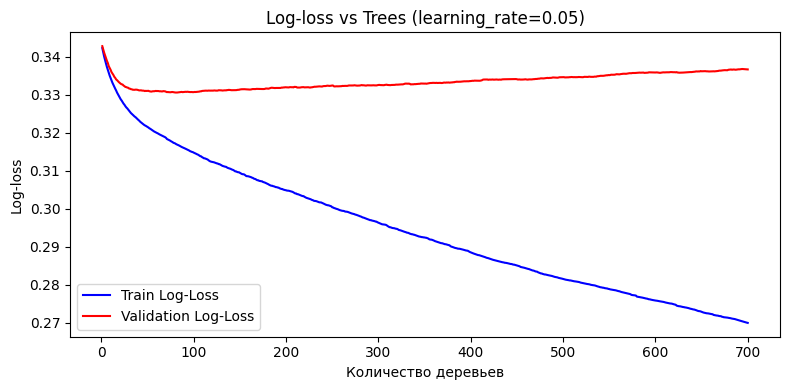

Log-loss на валидации (0.05): 0.336715

 Обучаем модель с learning_rate=0.01


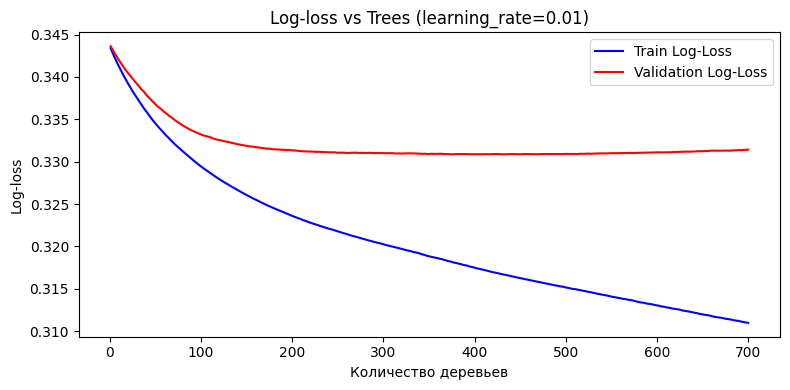

Log-loss на валидации (0.01): 0.331424

 Обучаем модель с learning_rate=0.001


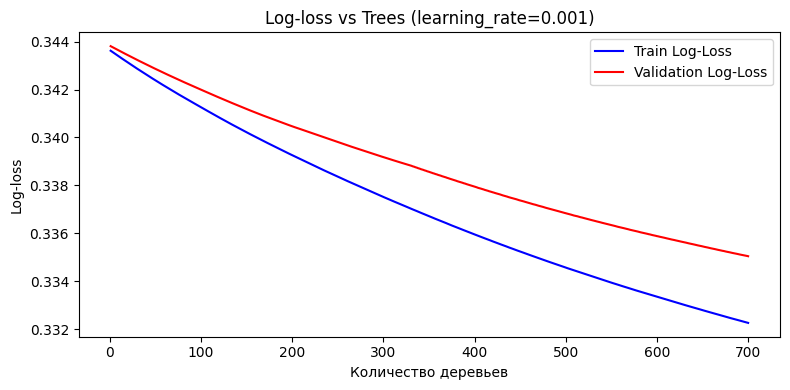

Log-loss на валидации (0.001): 0.335042


In [143]:
X_tr_enc = CT.fit_transform(X_tr)
X_val_enc = CT.transform(X_val)

#Функция для построения log-loss
def plot_learning_tree_logloss(estimator, X_tr, X_val, y_tr, y_val, learning_rate=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    n_estimators = estimator.n_estimators_
    zero = np.zeros(n_estimators, dtype=np.float64)

    #на train
    train_loss = zero.copy()
    for i, y_pred_train in enumerate(estimator.staged_predict_proba(X_tr)):
        train_loss[i] = log_loss(y_tr, y_pred_train)

    #на validation
    val_loss = zero.copy()
    for i, y_pred_val in enumerate(estimator.staged_predict_proba(X_val)):
        val_loss[i] = log_loss(y_val, y_pred_val)

    ax.plot(np.arange(1, n_estimators + 1), train_loss, '-', color='blue', label='Train Log-Loss')
    ax.plot(np.arange(1, n_estimators + 1), val_loss, '-', color='red', label='Validation Log-Loss')

    ax.legend(loc='best')
    ax.set_title(f'Log-loss vs Trees (learning_rate={learning_rate})')
    ax.set_xlabel('Количество деревьев')
    ax.set_ylabel('Log-loss')
    plt.tight_layout()
    plt.show()

#Обучаем модели с разными learning_rate
for lr in [0.05, 0.01, 0.001]:
    print(f"\n Обучаем модель с learning_rate={lr}")
    clf = GradientBoostingClassifier(
        n_estimators=700,
        learning_rate=lr,
        random_state=42
    )
    clf.fit(X_tr_enc, y_tr)

    
    plot_learning_tree_logloss(clf, X_tr_enc, X_val_enc, y_tr, y_val, learning_rate=lr)

    y_pred_val = clf.predict_proba(X_val_enc)
    print(f"Log-loss на валидации ({lr}): {log_loss(y_val, y_pred_val):.6f}")

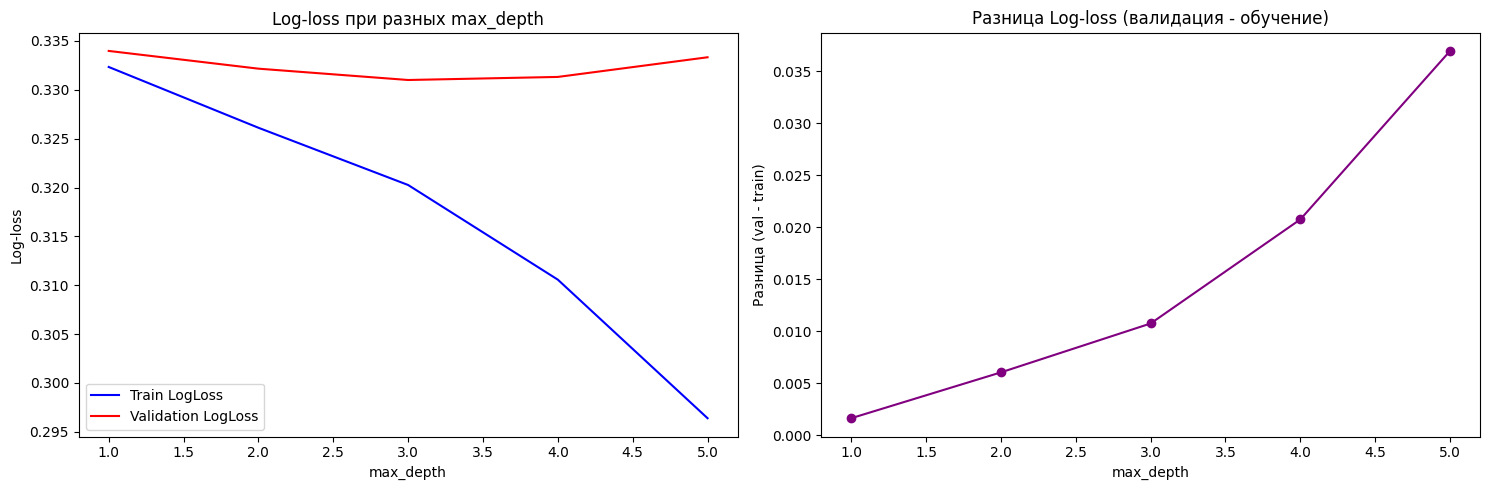

In [145]:
original_params = {
    "n_estimators": 300,
    "learning_rate": 0.01,
    "random_state": 42
}

max_depths = range(1, 6)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_logloss = []
val_logloss = []

#Перебор max_depth 
for depth in max_depths:
    params = dict(original_params)
    params["max_depth"] = depth
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_tr_enc, y_tr)

    # Log-loss
    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация
axes[0].plot(max_depths, train_logloss, label="Train LogLoss", color="blue")
axes[0].plot(max_depths, val_logloss, label="Validation LogLoss", color="red")
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("Log-loss")
axes[0].legend()
axes[0].set_title("Log-loss при разных max_depth")

#разница train-val 
axes[1].plot(max_depths, [v - t for v, t in zip(val_logloss, train_logloss)], 
             color="purple", marker='o')
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("Разница (val - train)")
axes[1].set_title("Разница Log-loss (валидация - обучение)")

plt.tight_layout()
plt.show()

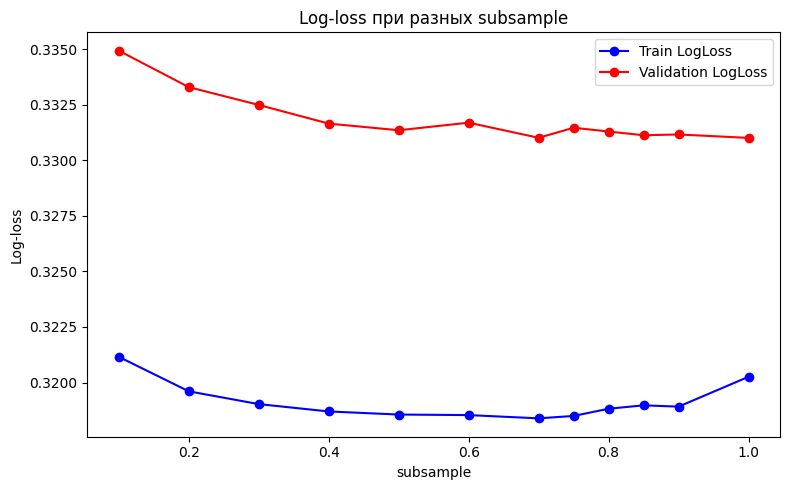

In [147]:
original_params = {
    "n_estimators": 300,
    "learning_rate": 0.01,
    "max_depth": 3,
    "random_state": 42
}

subsamples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

fig, ax = plt.subplots(figsize=(8, 5))

train_logloss = []
val_logloss = []

#Перебор subsample
for subsample_val in subsamples:
    params = dict(original_params)
    params["subsample"] = subsample_val
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_tr_enc, y_tr)

    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация
ax.plot(subsamples, train_logloss, label="Train LogLoss", color="blue", marker="o")
ax.plot(subsamples, val_logloss, label="Validation LogLoss", color="red", marker="o")
ax.set_xlabel("subsample")
ax.set_ylabel("Log-loss")
ax.legend(loc='best')
ax.set_title("Log-loss при разных subsample")

plt.tight_layout()
plt.show()

##### С калибровкой

In [149]:
base_model = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.01, max_depth = 3, subsample = 0.7)
base_model.fit(X_tr_enc, y_tr)

#логлосс ДО
y_pred_base = base_model.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка модели
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val_enc, y_val)

#логлосс ПОСЛЕ
y_pred_cal = calibrated.predict_proba(X_val_enc)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.331172
Log-loss после калибровки: 0.324305


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### RandomForest

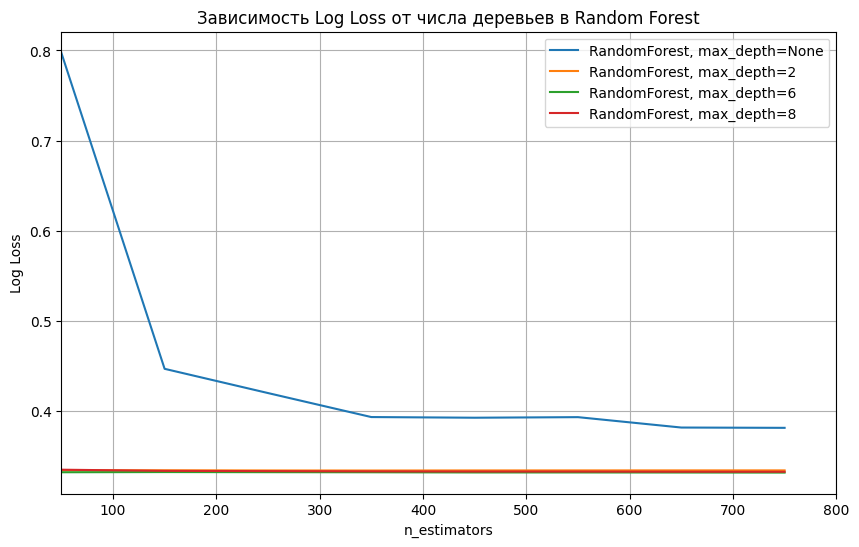

In [151]:
RANDOM_STATE = 42 

#Разные глубины деревьев
ensemble_clfs = [
    ("RandomForest, max_depth=None", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=None,
    )),
    ("RandomForest, max_depth=2", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=2,
    )),
    ("RandomForest, max_depth=6", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=6,
    )),
    ("RandomForest, max_depth=8", RandomForestClassifier(
        n_jobs=-1,
        warm_start=True,
        random_state=RANDOM_STATE,
        max_depth=8,
    )),
]

#Хранилище результатов
logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)
        y_pred_proba = clf.predict_proba(X_val_enc)
        score = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, score))

#Визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.title("Зависимость Log Loss от числа деревьев в Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.show()

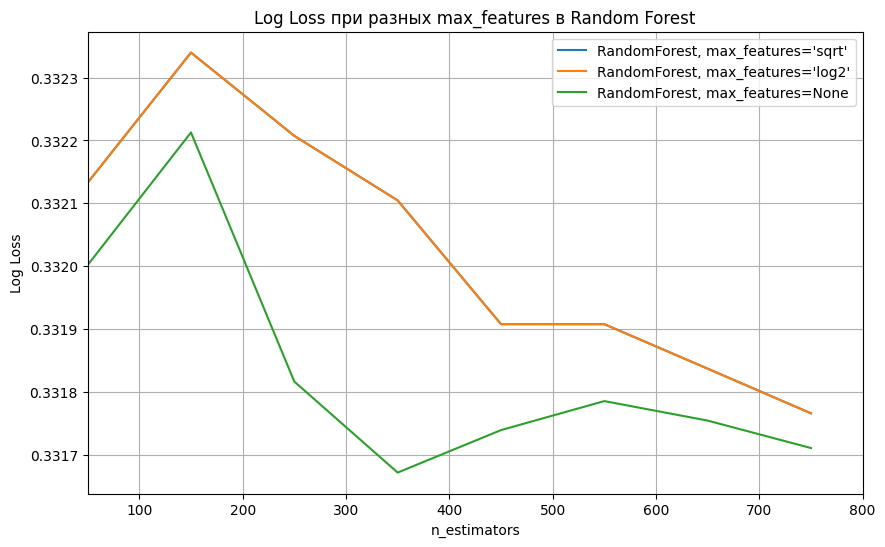

In [153]:
ensemble_clfs = [
    (
        "RandomForest, max_features='sqrt'",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, max_features='log2'",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features="log2",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, max_features=None",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features=None,
            random_state=RANDOM_STATE,
        ),
    ),
]

logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)

        y_pred_proba = clf.predict_proba(X_val_enc)
        logloss = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, logloss))

#Визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.legend(loc="best")
plt.title("Log Loss при разных max_features в Random Forest")
plt.grid(True)
plt.show()

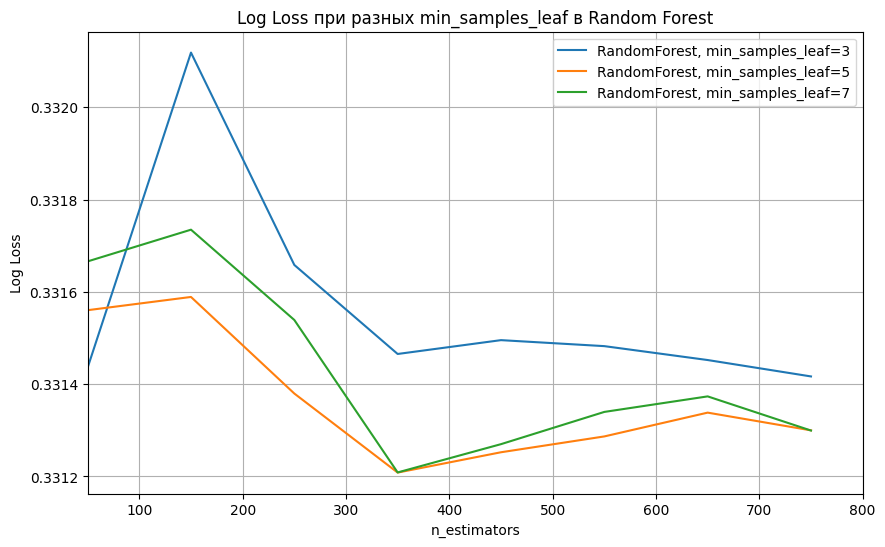

In [157]:
ensemble_clfs = [
    (
        "RandomForest, min_samples_leaf=3",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features=None,
            min_samples_split=2,
            min_samples_leaf=3,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_leaf=5",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features=None,
            min_samples_split=2,
            min_samples_leaf=5,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForest, min_samples_leaf=7",
        RandomForestClassifier(
            n_jobs=-1,
            max_depth=6,
            warm_start=True,
            max_features=None,
            min_samples_split=2,
            min_samples_leaf=7,
            random_state=RANDOM_STATE,
        ),
    ),
]

logloss_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 800  

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 100):
        clf.set_params(n_estimators=i)
        clf.fit(X_tr_enc, y_tr)

        y_pred_proba = clf.predict_proba(X_val_enc)
        loss = log_loss(y_val, y_pred_proba)
        logloss_scores[label].append((i, loss))

# визуализация
plt.figure(figsize=(10, 6))
for label, clf_scores in logloss_scores.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Log Loss")
plt.title("Log Loss при разных min_samples_leaf в Random Forest")
plt.legend(loc="best")
plt.grid(True)
plt.show()

##### с калибровкой

In [159]:
base_model = RandomForestClassifier(n_estimators=350, oob_score = True, max_depth = 6, min_samples_leaf=5,
                                  max_features=None, min_samples_split = 2, n_jobs=-1)
base_model.fit(X_tr_enc, y_tr)

#логлосс ДО
y_pred_base = base_model.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка 
calibrated = CalibratedClassifierCV(base_model, cv='prefit', method='isotonic')
calibrated.fit(X_val_enc, y_val)

#логлосс ПОСЛЕ 
y_pred_cal = calibrated.predict_proba(X_val_enc)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.331396
Log-loss после калибровки: 0.325360


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Catboost


 Обучаем модель с learning_rate=0.005
0:	learn: 0.6887784	test: 0.6888175	best: 0.6888175 (0)	total: 6.11ms	remaining: 6.1s
100:	learn: 0.4381249	test: 0.4394265	best: 0.4394265 (100)	total: 203ms	remaining: 1.81s
200:	learn: 0.3629884	test: 0.3659404	best: 0.3659404 (200)	total: 390ms	remaining: 1.55s
300:	learn: 0.3379957	test: 0.3429666	best: 0.3429666 (300)	total: 581ms	remaining: 1.35s
400:	learn: 0.3281958	test: 0.3350657	best: 0.3350657 (400)	total: 770ms	remaining: 1.15s
500:	learn: 0.3234229	test: 0.3322504	best: 0.3322504 (500)	total: 961ms	remaining: 958ms
600:	learn: 0.3204941	test: 0.3312670	best: 0.3312670 (600)	total: 1.16s	remaining: 767ms
700:	learn: 0.3181979	test: 0.3308585	best: 0.3308437 (698)	total: 1.35s	remaining: 574ms
800:	learn: 0.3162448	test: 0.3308202	best: 0.3307812 (773)	total: 1.54s	remaining: 383ms
900:	learn: 0.3144660	test: 0.3309002	best: 0.3307812 (773)	total: 1.74s	remaining: 191ms
999:	learn: 0.3128431	test: 0.3310111	best: 0.3307812 (773)	total

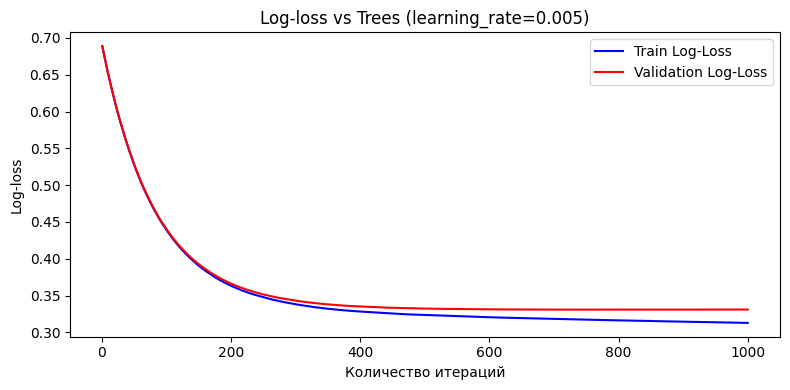

Log-loss на валидации (0.005): 0.330781
Лучшая итерация: 773

 Обучаем модель с learning_rate=0.01
0:	learn: 0.6844417	test: 0.6845191	best: 0.6845191 (0)	total: 2.82ms	remaining: 2.82s
100:	learn: 0.3630931	test: 0.3659369	best: 0.3659369 (100)	total: 242ms	remaining: 2.15s
200:	learn: 0.3286987	test: 0.3350505	best: 0.3350505 (200)	total: 427ms	remaining: 1.7s
300:	learn: 0.3205329	test: 0.3311904	best: 0.3311904 (300)	total: 619ms	remaining: 1.44s
400:	learn: 0.3162599	test: 0.3307822	best: 0.3307642 (385)	total: 814ms	remaining: 1.22s
500:	learn: 0.3128901	test: 0.3310138	best: 0.3307379 (432)	total: 1.01s	remaining: 1.01s
600:	learn: 0.3099257	test: 0.3314057	best: 0.3307379 (432)	total: 1.21s	remaining: 802ms
700:	learn: 0.3070526	test: 0.3319099	best: 0.3307379 (432)	total: 1.41s	remaining: 599ms
800:	learn: 0.3043121	test: 0.3322919	best: 0.3307379 (432)	total: 1.6s	remaining: 398ms
900:	learn: 0.3014361	test: 0.3327528	best: 0.3307379 (432)	total: 1.8s	remaining: 198ms
999:	le

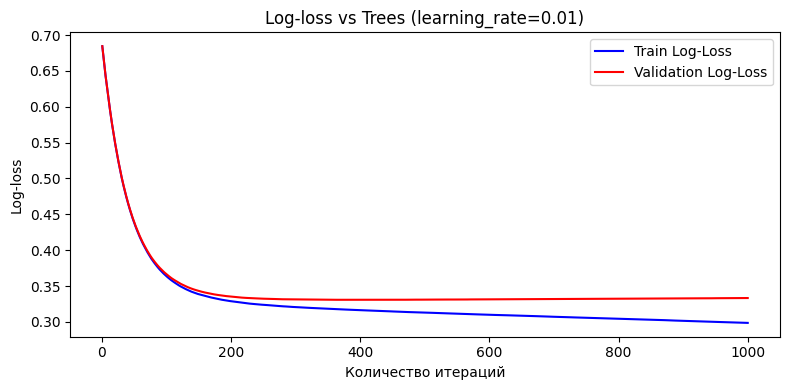

Log-loss на валидации (0.01): 0.330738
Лучшая итерация: 432

 Обучаем модель с learning_rate=0.05
0:	learn: 0.6509069	test: 0.6512536	best: 0.6512536 (0)	total: 2.8ms	remaining: 2.8s
100:	learn: 0.3124234	test: 0.3313590	best: 0.3310093 (87)	total: 251ms	remaining: 2.23s
200:	learn: 0.2984478	test: 0.3336334	best: 0.3310093 (87)	total: 446ms	remaining: 1.77s
300:	learn: 0.2840022	test: 0.3362679	best: 0.3310093 (87)	total: 643ms	remaining: 1.49s
400:	learn: 0.2705174	test: 0.3378284	best: 0.3310093 (87)	total: 838ms	remaining: 1.25s
500:	learn: 0.2589489	test: 0.3401497	best: 0.3310093 (87)	total: 1.04s	remaining: 1.03s
600:	learn: 0.2487754	test: 0.3430344	best: 0.3310093 (87)	total: 1.23s	remaining: 819ms
700:	learn: 0.2388696	test: 0.3450744	best: 0.3310093 (87)	total: 1.43s	remaining: 610ms
800:	learn: 0.2295821	test: 0.3477092	best: 0.3310093 (87)	total: 1.63s	remaining: 404ms
900:	learn: 0.2209632	test: 0.3494016	best: 0.3310093 (87)	total: 1.83s	remaining: 201ms
999:	learn: 0.21

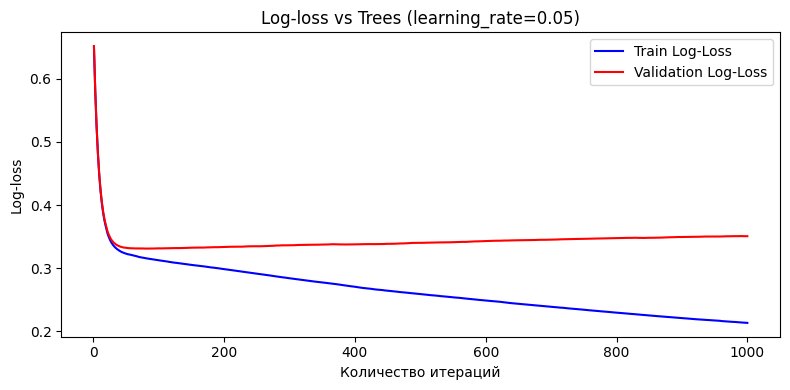

Log-loss на валидации (0.05): 0.331009
Лучшая итерация: 87

 Обучаем модель с learning_rate=0.1
0:	learn: 0.6118406	test: 0.6124659	best: 0.6124659 (0)	total: 3.56ms	remaining: 3.56s
100:	learn: 0.2997350	test: 0.3325418	best: 0.3289313 (48)	total: 253ms	remaining: 2.25s
200:	learn: 0.2702347	test: 0.3367825	best: 0.3289313 (48)	total: 481ms	remaining: 1.91s
300:	learn: 0.2471219	test: 0.3405088	best: 0.3289313 (48)	total: 683ms	remaining: 1.59s
400:	learn: 0.2283563	test: 0.3440047	best: 0.3289313 (48)	total: 881ms	remaining: 1.31s
500:	learn: 0.2118941	test: 0.3492382	best: 0.3289313 (48)	total: 1.09s	remaining: 1.08s
600:	learn: 0.1971862	test: 0.3537760	best: 0.3289313 (48)	total: 1.28s	remaining: 853ms
700:	learn: 0.1823766	test: 0.3583379	best: 0.3289313 (48)	total: 1.48s	remaining: 632ms
800:	learn: 0.1701608	test: 0.3601940	best: 0.3289313 (48)	total: 1.68s	remaining: 417ms
900:	learn: 0.1587362	test: 0.3637353	best: 0.3289313 (48)	total: 1.88s	remaining: 206ms
999:	learn: 0.14

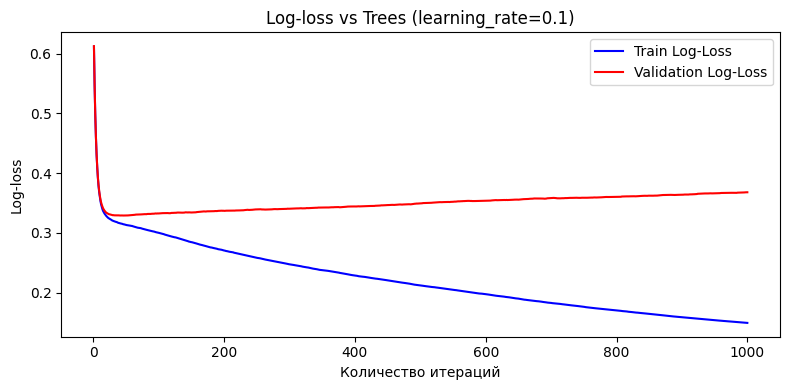

Log-loss на валидации (0.1): 0.328931
Лучшая итерация: 48


In [163]:
def plot_catboost_learning_curve(estimator, learning_rate=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    evals_result = estimator.get_evals_result()
    
    if 'learn' in evals_result and 'validation' in evals_result:
        train_loss = evals_result['learn']['Logloss']
        val_loss = evals_result['validation']['Logloss']
        
        ax.plot(np.arange(1, len(train_loss) + 1), train_loss, '-', color='blue', label='Train Log-Loss')
        ax.plot(np.arange(1, len(val_loss) + 1), val_loss, '-', color='red', label='Validation Log-Loss')
        
        ax.legend(loc='best')
        ax.set_title(f'Log-loss vs Trees (learning_rate={learning_rate})')
        ax.set_xlabel('Количество итераций')
        ax.set_ylabel('Log-loss')
        plt.tight_layout()
        plt.show()
    else:
        print("История обучения недоступна")

# Обучаем модели
for lr in [0.005, 0.01, 0.05, 0.1]:
    print(f"\n Обучаем модель с learning_rate={lr}")
    clf = CatBoostClassifier(
        iterations=1000,
        learning_rate=lr,
        random_state=42,
        verbose=100,
        eval_metric='Logloss'
    )
    
    clf.fit(
        X_tr_enc, y_tr,
        eval_set=(X_val_enc, y_val),
        verbose=100
    )

    plot_catboost_learning_curve(clf, learning_rate=lr)
    
    y_pred_val = clf.predict_proba(X_val_enc)
    print(f"Log-loss на валидации ({lr}): {log_loss(y_val, y_pred_val):.6f}")
    print(f"Лучшая итерация: {clf.get_best_iteration()}")

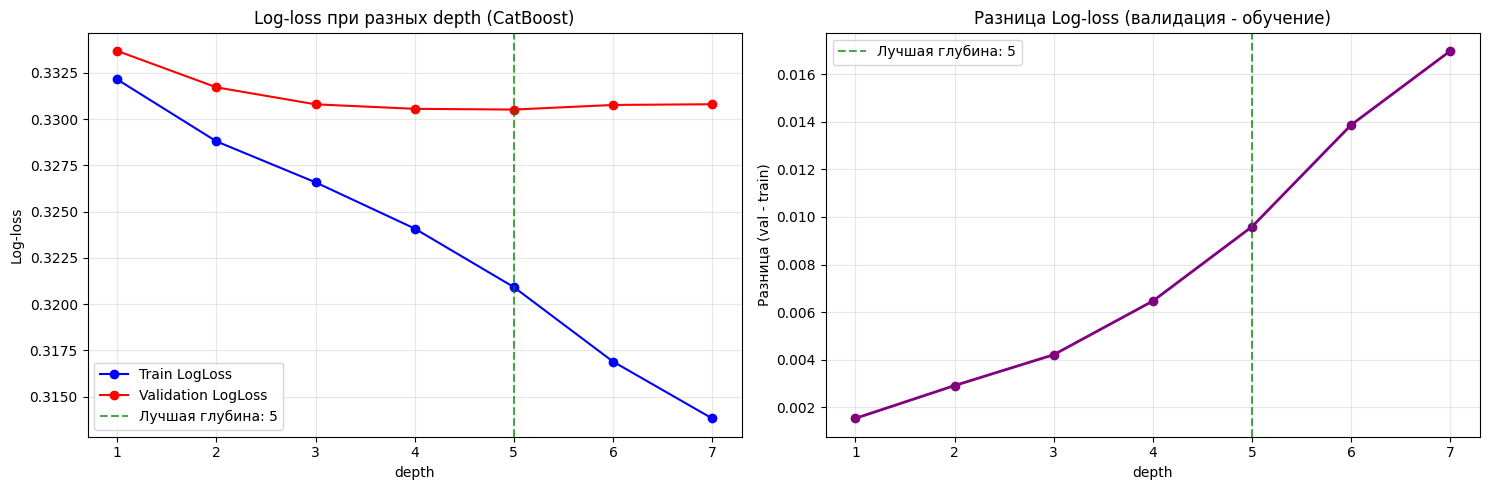


Лучшая глубина: 5
Лучший log-loss на валидации: 0.3305


In [165]:
original_params = {
    "iterations": 400,  
    "learning_rate": 0.01,
    "random_state": 42,
    "verbose": False  
}

max_depths = range(1, 8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_logloss = []
val_logloss = []

#Перебор max_depth 
for depth in max_depths:
    params = dict(original_params)
    params["depth"] = depth  
    
    clf = CatBoostClassifier(**params)
    clf.fit(X_tr_enc, y_tr, eval_set=(X_val_enc, y_val), verbose=False)

    # Log-loss
    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)
    

# Визуализация
axes[0].plot(max_depths, train_logloss, label="Train LogLoss", color="blue", marker='o')
axes[0].plot(max_depths, val_logloss, label="Validation LogLoss", color="red", marker='o')
axes[0].set_xlabel("depth")
axes[0].set_ylabel("Log-loss")
axes[0].legend()
axes[0].set_title("Log-loss при разных depth (CatBoost)")
axes[0].grid(True, alpha=0.3)

#Разница train-val 
axes[1].plot(max_depths, [v - t for v, t in zip(val_logloss, train_logloss)], 
             color="purple", marker='o', linewidth=2)
axes[1].set_xlabel("depth")
axes[1].set_ylabel("Разница (val - train)")
axes[1].set_title("Разница Log-loss (валидация - обучение)")
axes[1].grid(True, alpha=0.3)

best_depth_idx = np.argmin(val_logloss)
best_depth = max_depths[best_depth_idx]
axes[0].axvline(x=best_depth, color='green', linestyle='--', alpha=0.7, 
                label=f'Лучшая глубина: {best_depth}')
axes[0].legend()

axes[1].axvline(x=best_depth, color='green', linestyle='--', alpha=0.7,
                label=f'Лучшая глубина: {best_depth}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nЛучшая глубина: {best_depth}")
print(f"Лучший log-loss на валидации: {val_logloss[best_depth_idx]:.4f}")

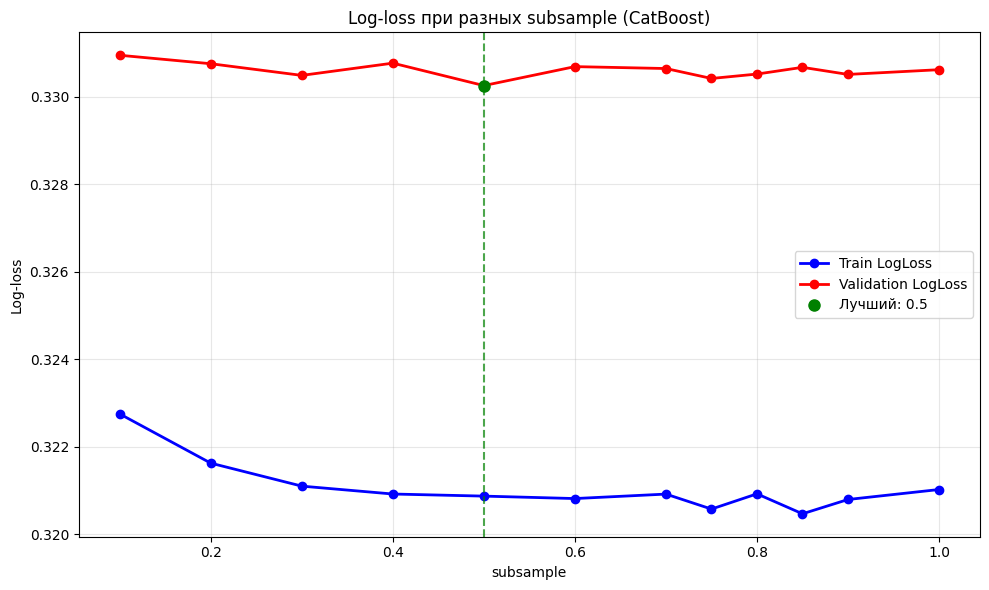


Лучший subsample: 0.5
Log-loss на валидации: 0.3303


In [167]:
original_params = {
    "iterations": 400,  
    "learning_rate": 0.01,
    "depth": 5,         
    "random_state": 42,
    "verbose": False    
}

subsamples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

fig, ax = plt.subplots(figsize=(10, 6))

train_logloss = []
val_logloss = []

#Перебор subsample
for subsample_val in subsamples:
    params = dict(original_params)
    params["subsample"] = subsample_val
    clf = CatBoostClassifier(**params)
    clf.fit(X_tr_enc, y_tr, eval_set=(X_val_enc, y_val), verbose=False)

    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация
ax.plot(subsamples, train_logloss, label="Train LogLoss", color="blue", marker="o", linewidth=2)
ax.plot(subsamples, val_logloss, label="Validation LogLoss", color="red", marker="o", linewidth=2)
ax.set_xlabel("subsample")
ax.set_ylabel("Log-loss")
ax.legend(loc='best')
ax.set_title("Log-loss при разных subsample (CatBoost)")
ax.grid(True, alpha=0.3)

best_idx = np.argmin(val_logloss)
best_subsample = subsamples[best_idx]
best_val_loss = val_logloss[best_idx]

ax.axvline(x=best_subsample, color='green', linestyle='--', alpha=0.7)
ax.plot(best_subsample, best_val_loss, 'go', markersize=8, label=f'Лучший: {best_subsample}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nЛучший subsample: {best_subsample}")
print(f"Log-loss на валидации: {best_val_loss:.4f}")

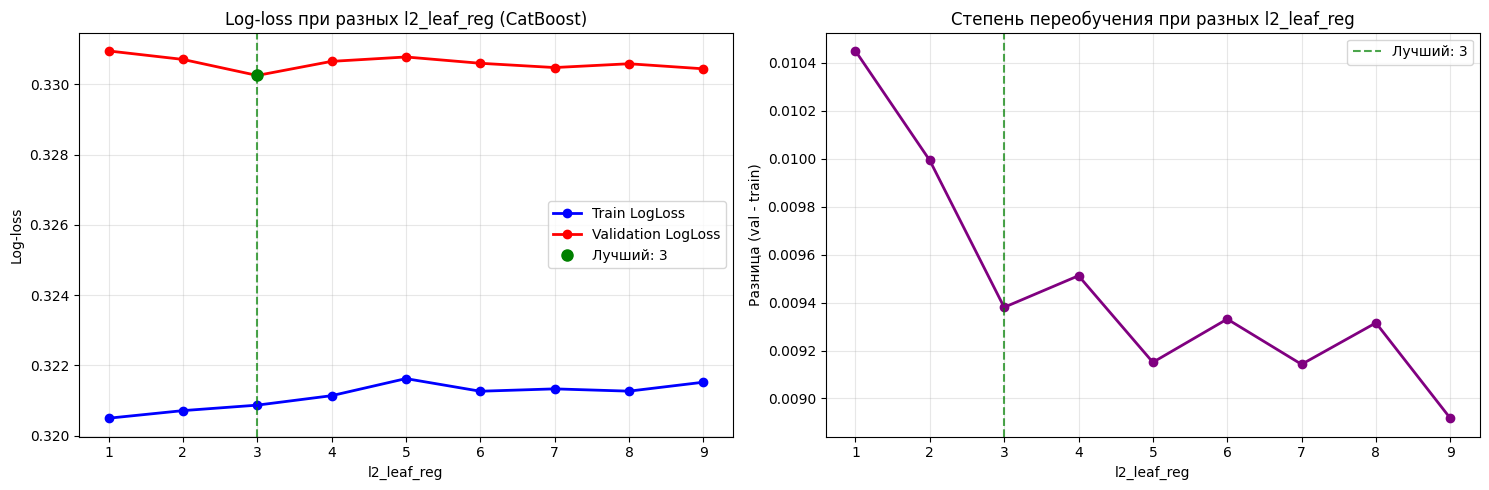


Лучший l2_leaf_reg: 3
Log-loss на валидации: 0.3303


In [169]:
original_params = {
    "iterations": 400,
    "learning_rate": 0.01,
    "depth": 5,
    "subsample": 0.5,
    "random_state": 42,
    "verbose": False
}

l2_leaf_reg_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_logloss = []
val_logloss = []

#Перебор l2_leaf_reg
for l2_reg in l2_leaf_reg_values:
    params = dict(original_params)
    params["l2_leaf_reg"] = l2_reg
    clf = CatBoostClassifier(**params)
    clf.fit(X_tr_enc, y_tr, eval_set=(X_val_enc, y_val), verbose=False)

    train_logloss_val = log_loss(y_tr, clf.predict_proba(X_tr_enc))
    val_logloss_val = log_loss(y_val, clf.predict_proba(X_val_enc))

    train_logloss.append(train_logloss_val)
    val_logloss.append(val_logloss_val)

#Визуализация Log-loss
axes[0].plot(l2_leaf_reg_values, train_logloss, label="Train LogLoss", color="blue", marker="o", linewidth=2)
axes[0].plot(l2_leaf_reg_values, val_logloss, label="Validation LogLoss", color="red", marker="o", linewidth=2)
axes[0].set_xlabel("l2_leaf_reg")
axes[0].set_ylabel("Log-loss")
axes[0].legend(loc='best')
axes[0].set_title("Log-loss при разных l2_leaf_reg (CatBoost)")
axes[0].grid(True, alpha=0.3)

#Разница между train и validation
overfitting_gap = [val - train for val, train in zip(val_logloss, train_logloss)]
axes[1].plot(l2_leaf_reg_values, overfitting_gap, color="purple", marker="o", linewidth=2)
axes[1].set_xlabel("l2_leaf_reg")
axes[1].set_ylabel("Разница (val - train)")
axes[1].set_title("Степень переобучения при разных l2_leaf_reg")
axes[1].grid(True, alpha=0.3)

best_idx = np.argmin(val_logloss)
best_l2_reg = l2_leaf_reg_values[best_idx]
best_val_loss = val_logloss[best_idx]

axes[0].axvline(x=best_l2_reg, color='green', linestyle='--', alpha=0.7)
axes[0].plot(best_l2_reg, best_val_loss, 'go', markersize=8, label=f'Лучший: {best_l2_reg}')
axes[0].legend()

axes[1].axvline(x=best_l2_reg, color='green', linestyle='--', alpha=0.7, label=f'Лучший: {best_l2_reg}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nЛучший l2_leaf_reg: {best_l2_reg}")
print(f"Log-loss на валидации: {best_val_loss:.4f}")

##### С калибровкой

In [172]:
model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.01,
    depth=5,
    subsample=0.5,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False
)
model.fit(X_tr_enc, y_tr)

#логлосс ДО
y_pred_base = model.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss до калибровки: {logloss_before:.6f}")

#Калибровка 
calibrated = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
calibrated.fit(X_val_enc, y_val)

#логлосс ПОСЛЕ 
y_pred_cal = calibrated.predict_proba(X_val_enc)[:, 1]
logloss_after = log_loss(y_val, y_pred_cal)
print(f"Log-loss после калибровки: {logloss_after:.6f}")

Log-loss до калибровки: 0.330256
Log-loss после калибровки: 0.325062


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### NN

In [174]:
class RewardNet(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, dropout=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x)

#Обучение и вывод логлосса
def train_reward_nn(X_tr_enc, y_tr, X_val_enc, y_val,
                    lr=1e-5, batch_size=64, n_epochs=50, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #преобразуем в numpy 
    X_tr = np.asarray(X_tr_enc, dtype=np.float32)
    X_val = np.asarray(X_val_enc, dtype=np.float32)
    y_tr = np.asarray(y_tr, dtype=np.float32).reshape(-1, 1)
    y_val = np.asarray(y_val, dtype=np.float32).reshape(-1, 1)

    #DataLoaders
    train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
    val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = RewardNet(X_tr.shape[1]).to(device)

    #Считаем pos_weight для баланса классов
    pos_weight = torch.tensor([(len(y_tr) - y_tr.sum()) / y_tr.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    best_val_loss = np.inf
    no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(xb)

        #Валидация
        model.eval()
        val_logits, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.to(device)
                out = model(xb)
                val_logits.append(out.cpu().numpy())
                val_targets.append(yb.numpy())

        val_logits = np.vstack(val_logits).ravel()
        val_targets = np.vstack(val_targets).ravel()

        val_probs = 1 / (1 + np.exp(-val_logits))
        val_logloss = log_loss(val_targets, val_probs)
        train_loss /= len(X_tr)

        print(f"Epoch {epoch:03d}: train_loss={train_loss:.5f}, val_logloss={val_logloss:.5f}")

        if val_logloss < best_val_loss - 1e-6:
            best_val_loss = val_logloss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping! Best val_logloss = {best_val_loss:.6f}")
                break

    print(f"\nФинальный log-loss на валидации: {best_val_loss:.6f}")

In [176]:
train_reward_nn(X_tr_enc, y_tr, X_val_enc, y_val)

Epoch 001: train_loss=1.26704, val_logloss=0.63007
Epoch 002: train_loss=1.25800, val_logloss=0.63706
Epoch 003: train_loss=1.25727, val_logloss=0.63429
Epoch 004: train_loss=1.24516, val_logloss=0.63837
Epoch 005: train_loss=1.22505, val_logloss=0.63493
Epoch 006: train_loss=1.22162, val_logloss=0.64325
Early stopping! Best val_logloss = 0.630065

Финальный log-loss на валидации: 0.630065


#### Voting

In [180]:
base_model_lr = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=10000)
base_model_lr.fit(X_tr_enc, y_tr)
y_pred_base = base_model_lr.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss logreg: {logloss_before:.6f}")

base_model_cb = CatBoostClassifier(
     iterations=400,
    learning_rate=0.01,
    depth=5,
    subsample=0.5,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False)
base_model_cb.fit(X_tr_enc, y_tr)
y_pred_base = base_model_cb.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss catboost: {logloss_before:.6f}")


base_model_rf = RandomForestClassifier(n_estimators=350, oob_score = True, max_depth = 6, min_samples_leaf=5,
                                  max_features=None, min_samples_split = 2, n_jobs=-1)
base_model_rf.fit(X_tr_enc, y_tr)
y_pred_base = base_model_rf.predict_proba(X_val_enc)[:, 1]
logloss_before = log_loss(y_val, y_pred_base)
print(f"Log-loss randomforest: {logloss_before:.6f}")

Log-loss logreg: 0.331016
Log-loss catboost: 0.330256
Log-loss randomforest: 0.331737


In [181]:
voting = VotingClassifier(
    estimators=[
        ('lr', base_model_lr),
        ('rf', base_model_rf),
        ('cb', base_model_cb)
    ],
    voting='soft'
)
voting.fit(X_tr_enc, y_tr)

print("Log-loss voting (before calib):", log_loss(y_val, voting.predict_proba(X_val_enc)))

# 3) калибруем уже готовый ансамбль
calibrated_voting = CalibratedClassifierCV(voting, cv='prefit', method='isotonic')
calibrated_voting.fit(X_val_enc, y_val)

print("Log-loss voting (after calib):", log_loss(y_val, calibrated_voting.predict_proba(X_val_enc)))

Log-loss voting (before calib): 0.3300406676232566
Log-loss voting (after calib): 0.3233894608213015


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


#### Stacking

In [185]:
#Базовые модели
base_model_lr = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=10000)

base_model_cb = CatBoostClassifier(
    iterations=400,
    learning_rate=0.01,
    depth=5,
    subsample=0.5,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False)

base_model_rf = RandomForestClassifier(n_estimators=350, oob_score = True, max_depth = 6, min_samples_leaf=5,
                                  max_features=None, min_samples_split = 2, n_jobs=-1)

#Мета-модель
meta_model = LogisticRegression(max_iter=5000)

#Стекинг
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', base_model_lr),
        ('rf', base_model_rf),
        ('cb', base_model_cb)
    ],
    final_estimator=meta_model,
    stack_method='predict_proba',  
    passthrough=False,             
    cv=5,                          
    n_jobs=-1
)


stacking_clf.fit(X_tr_enc, y_tr)
val_proba = stacking_clf.predict_proba(X_val_enc)[:, 1]
print(f"Log-loss стекинга: {log_loss(y_val, val_proba):.6f}")

Log-loss стекинга: 0.332003


In [186]:
calibrated_stacking = CalibratedClassifierCV(stacking_clf, cv='prefit', method='isotonic')
calibrated_stacking.fit(X_val_enc, y_val)

print("Log-loss voting (after calib):", log_loss(y_val, calibrated_stacking.predict_proba(X_val_enc)))

Log-loss voting (after calib): 0.3234402416936794


/opt/anaconda3/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


### Сравнение моделей по логлоссу (все дают примерно одинаковый результат):

In [216]:
print('Логлоссы для 1-ой reward модели: Mens E-Mail')
results_df1 = pd.DataFrame({
    'Логрег': [0.465185],
    'Логрег+калибр':[0.460494],
    'Бустинг':[0.464789],
    'Бустинг+калибр':[0.460158],
    'Лес':[0.465652],
    'Лес+калибр':[0.461841],
    'KNN':[0.476942],
    'KNN+калибр':[0.471176],
    'Catboost':[0.464641],
    'Catboost+калибр':[0.459507],
    'NN':[0.676466],
    'Voting':[0.464629],
    'Voting+калибр':[0.460154],
    'Stacking':[0.465134],
    'Stacking+калибр':[0.459702]
      
})
sorted_results1 = results_df1.T.sort_values(by=0)
sorted_results1.columns = ['LogLoss']
display(sorted_results1.T)


print('Логлоссы для 2-ой reward модели: Womens E-Mail')

print('Логлоссы для 3-ей reward модели: No E-Mail')

Логлоссы для 1-ой reward модели: Mens E-Mail


,Catboost+калибр,Stacking+калибр,Voting+калибр,Бустинг+калибр,Логрег+калибр,Лес+калибр,Voting,Catboost,Бустинг,Stacking,Логрег,Лес,KNN+калибр,KNN,NN
LogLoss,0.459507,0.459702,0.460154,0.460158,0.460494,0.461841,0.464629,0.464641,0.464789,0.465134,0.465185,0.465652,0.471176,0.476942,0.676466


Логлоссы для 2-ой reward модели: Womens E-Mail
Логлоссы для 3-ей reward модели: No E-Mail


## Функции для итоговой политики и рассчета скора

### Через softmax преобразование

In [98]:
def evaluate_softmax_snips(Q, y_true, V_best, taus=None, m=1/3, show_table=True):

    if taus is None:
        taus = [0.05, 0.1, 0.2, 0.5, 1.0]

    action_map = {'Mens E-Mail': 0, 'Womens E-Mail': 1, 'No E-Mail': 2}
    a_idx = y_true.segment.map(action_map).values
    r = y_true.visit.values

    results = []

    for tau in taus:
        # softmax
        pi = np.exp(Q / tau) / np.exp(Q / tau).sum(axis=1, keepdims=True)

        # достаём вероятность выбранного действия
        pi_a = pi[np.arange(len(pi)), a_idx]
        weights = pi_a / m

        snips = np.sum(weights * r) / np.sum(weights)
        score = snips - V_best

        results.append({
            'tau': tau,
            'SNIPS': snips,
            'score': score
        })

    df_results = pd.DataFrame(results).sort_values(by=['SNIPS', 'score'], ascending=False).reset_index(drop=True)

    if show_table:
        print("\n Результаты после softmax преобразования (отсортированы по SNIPS и score):")
        display(df_results)
        best_row = df_results.iloc[0]
        print('Лучшая температура:', best_row.tau, 'Score:', best_row.score.round(5))

    return df_results

### Через $\varepsilon$-жадную стратегию

In [100]:
def evaluate_epsilon_snips(Q, y_true, V_best, epsilons=None, m=1/3, show_table=True):
    
    if epsilons is None:
        epsilons = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

    K = Q.shape[1]
    action_map = {'Mens E-Mail': 0, 'Womens E-Mail': 1, 'No E-Mail': 2}
    a_idx = y_true.segment.map(action_map).values
    r = y_true.visit.values

    results = []
    best_actions = np.argmax(Q, axis=1)

    for eps in epsilons:
        # e-жадное распределение
        pi = np.full_like(Q, eps / K, dtype=float)
        pi[np.arange(len(Q)), best_actions] += (1 - eps)
        
        # вероятность выбранного действия
        pi_a = pi[np.arange(len(pi)), a_idx]
        weights = pi_a / m

        # SNIPS и итоговый score
        snips = np.sum(weights * r) / np.sum(weights)
        score = snips - V_best

        results.append({'epsilon': eps, 'SNIPS': snips, 'score': score})

    df_results = pd.DataFrame(results).sort_values(by=['SNIPS', 'score'], ascending=False).reset_index(drop=True)

    if show_table:
        print("\n Результаты после применения e-жадной стратегии (отсортированы по SNIPS и score):")
        display(df_results)
        best_row = df_results.iloc[0]
        print('Лучшая ε:', best_row.epsilon, 'Score:', best_row.score.round(5))

    return df_results

### Итоговый выбор моделей и параметров для reward моделей

#### логрег

In [172]:
models = {}

for name, X_part, y_part in [
    ('mens', train_mens, y_mens),
    ('womens', train_womens, y_womens),
    ('noemail', train_none, y_none)
]:
    pipe = Pipeline(steps=[
        ('preprocess', CT),
        ('model', LogisticRegression(max_iter=10000))
    ])
    pipe.fit(X_part, y_part)
    models[name] = pipe

# Степень уверенности модели в том, что visit = 1
probs_mens = models['mens'].predict_proba(X_test)[:, 1]
probs_womens = models['womens'].predict_proba(X_test)[:, 1]
probs_none = models['noemail'].predict_proba(X_test)[:, 1]

Q = np.stack([probs_mens, probs_womens, probs_none], axis=1)
df_softmax_results = evaluate_softmax_snips(Q, y_test, V_best)
df_eps_results = evaluate_epsilon_snips(Q, y_test, V_best)


 Результаты после softmax преобразования (отсортированы по SNIPS и score):


,tau,SNIPS,score
0,0.05,0.170567,-0.018106
1,0.10,0.161244,-0.027429
2,0.20,0.155489,-0.033185
3,0.50,0.151792,-0.036881
4,1.00,0.150535,-0.038138


Лучшая температура: 0.05 Score: -0.01811

 Результаты после применения e-жадной стратегии (отсортированы по SNIPS и score):


,epsilon,SNIPS,score
0,0.00,0.186260,-0.002414
1,0.01,0.185898,-0.002775
2,0.05,0.184450,-0.004223
3,0.10,0.182637,-0.006036
4,0.20,0.178998,-0.009675
5,0.30,0.175342,-0.013331
6,0.50,0.167979,-0.020694


Лучшая ε: 0.0 Score: -0.00241


#### CatBoost

In [214]:
models = {}

for name, X_part, y_part in [
    ('mens', train_mens, y_mens),
    ('womens', train_womens, y_womens),
    ('noemail', train_none, y_none)
]:
    pipe = Pipeline(steps=[
        ('preprocess', CT),
        ('model', CatBoostClassifier(
    iterations=200,
    learning_rate=0.01,
    depth=7,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False))
    ])
    
    pipe.fit(X_part, y_part)
    models[name] = pipe

# Степень уверенности модели в том, что visit = 1
probs_mens = models['mens'].predict_proba(X_test)[:, 1]
probs_womens = models['womens'].predict_proba(X_test)[:, 1]
probs_none = models['noemail'].predict_proba(X_test)[:, 1]

Q = np.stack([probs_mens, probs_womens, probs_none], axis=1)
df_softmax_results = evaluate_softmax_snips(Q, y_test, V_best)
df_eps_results = evaluate_epsilon_snips(Q, y_test, V_best)


 Результаты после softmax преобразования (отсортированы по SNIPS и score):


,tau,SNIPS,score
0,0.05,0.170054,-0.018619
1,0.10,0.160972,-0.027701
2,0.20,0.155359,-0.033314
3,0.50,0.151744,-0.036929
4,1.00,0.150512,-0.038162


Лучшая температура: 0.05 Score: -0.01862

 Результаты после применения e-жадной стратегии (отсортированы по SNIPS и score):


,epsilon,SNIPS,score
0,0.00,0.188790,0.000116
1,0.01,0.188400,-0.000273
2,0.05,0.186841,-0.001832
3,0.10,0.184889,-0.003784
4,0.20,0.180978,-0.007696
5,0.30,0.177055,-0.011619
6,0.50,0.169174,-0.019499


Лучшая ε: 0.0 Score: 0.00012


#### GradientBoosting, LogisticRegression, RandomForest

In [176]:
name_map = {
    'mens': 'Mens E-Mail',
    'womens': 'Womens E-Mail',
    'noemail': 'No E-Mail'
}
models = {}

configs = {
    'mens': GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        random_state=42
    ),
    'womens': LogisticRegression(max_iter=1000000, C=1.0, solver='lbfgs'),
    'noemail': RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    )
}

for name, model in configs.items():
    pipe = Pipeline(steps=[
        ('preprocess', CT),
        ('model', model)
    ])
    
    X_part = X_train[y_train.segment == name_map[name]]
    y_part = y_train[y_train.segment == name_map[name]]['visit']
    
    pipe.fit(X_part, y_part)
    models[name] = pipe

# Степень уверенности модели в том, что visit = 1
probs_mens = models['mens'].predict_proba(X_test)[:, 1]
probs_womens = models['womens'].predict_proba(X_test)[:, 1]
probs_none = models['noemail'].predict_proba(X_test)[:, 1]

Q = np.stack([probs_mens, probs_womens, probs_none], axis=1)
df_softmax_results = evaluate_softmax_snips(Q, y_test, V_best)
df_eps_results = evaluate_epsilon_snips(Q, y_test, V_best)


 Результаты после softmax преобразования (отсортированы по SNIPS и score):


,tau,SNIPS,score
0,0.05,0.170187,-0.018486
1,0.10,0.163276,-0.025397
2,0.20,0.157848,-0.030825
3,0.50,0.153099,-0.035575
4,1.00,0.151191,-0.037482


Лучшая температура: 0.05 Score: -0.01849

 Результаты после применения e-жадной стратегии (отсортированы по SNIPS и score):


,epsilon,SNIPS,score
0,0.00,0.182938,-0.005735
1,0.01,0.182606,-0.006067
2,0.05,0.181278,-0.007395
3,0.10,0.179615,-0.009058
4,0.20,0.176283,-0.012390
5,0.30,0.172941,-0.015733
6,0.50,0.166227,-0.022446


Лучшая ε: 0.0 Score: -0.00574


In [178]:
# --- 1️⃣ Базовые модели (будут одинаковы для всех сегментов)
base_learners = [
    ('gb', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        random_state=42
    )),
    ('lr', LogisticRegression(max_iter=10000, C=1.0, solver='lbfgs')),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    ))
]

# --- 2️⃣ Мета-модель (научится комбинировать базовые)
meta_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.01,
    depth=7,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False)

# --- 3️⃣ Храним модели по сегментам
stack_models = {}

# --- 4️⃣ Обучаем по каждому сегменту отдельно
for seg_name, seg_label in {
    'mens': 'Mens E-Mail',
    'womens': 'Womens E-Mail',
    'noemail': 'No E-Mail'
}.items():
    
    # Отбираем данные для сегмента
    X_seg = X_train[y_train.segment == seg_label]
    y_seg = y_train[y_train.segment == seg_label]['visit']
    
    # Создаём стекинговый пайплайн (предобработка + стек)
    pipe = Pipeline(steps=[
        ('preprocess', CT),
        ('stack', StackingClassifier(
            estimators=base_learners,
            final_estimator=meta_model,
            cv=5,
            stack_method='predict_proba'
        ))
    ])
    
    print(f"🔹 Обучаем стек для сегмента: {seg_label}")
    pipe.fit(X_seg, y_seg)
    stack_models[seg_name] = pipe

print("\n✅ Все три стекинг-модели обучены!")

🔹 Обучаем стек для сегмента: Mens E-Mail
🔹 Обучаем стек для сегмента: Womens E-Mail
🔹 Обучаем стек для сегмента: No E-Mail

✅ Все три стекинг-модели обучены!


In [180]:
p_mens = stack_models['mens'].predict_proba(X_test)[:, 1]
p_womens = stack_models['womens'].predict_proba(X_test)[:, 1]
p_none = stack_models['noemail'].predict_proba(X_test)[:, 1]

# --- 6️⃣ Формируем Q-матрицу (3 действия)
Q = np.stack([p_mens, p_womens, p_none], axis=1)


In [182]:
df_softmax_results = evaluate_softmax_snips(Q, y_test, V_best)
df_eps_results = evaluate_epsilon_snips(Q, y_test, V_best)


 Результаты после softmax преобразования (отсортированы по SNIPS и score):


,tau,SNIPS,score
0,0.05,0.170864,-0.017810
1,0.10,0.161418,-0.027256
2,0.20,0.155596,-0.033077
3,0.50,0.151841,-0.036832
4,1.00,0.150561,-0.038113


Лучшая температура: 0.05 Score: -0.01781

 Результаты после применения e-жадной стратегии (отсортированы по SNIPS и score):


,epsilon,SNIPS,score
0,0.00,0.190078,0.001404
1,0.01,0.189673,0.000999
2,0.05,0.188052,-0.000621
3,0.10,0.186025,-0.002648
4,0.20,0.181967,-0.006706
5,0.30,0.177902,-0.010771
6,0.50,0.169754,-0.018920


Лучшая ε: 0.0 Score: 0.0014


## Загрузка результатов на kaagle

In [216]:
val = pd.read_csv('test.csv')
print('test from kaagle:')
display(val.head(3))

sample_submission = pd.read_csv('sample_submission.csv')
print('sample_submission:')
display(sample_submission.head(3))

test from kaagle:


,id,recency,history,mens,womens,newbie,zip_code,channel,history_segment
0,13512,8,74.26,0,1,0,Rural,Web,1) $0 - $100
1,900,1,1606.11,1,1,1,Urban,Phone,"7) $1,000 +"
2,40793,10,44.77,1,0,1,Urban,Phone,1) $0 - $100


sample_submission:


,id,p_mens_email,p_womens_email,p_no_email
0,13512,0.333333,0.333333,0.333333
1,900,0.333333,0.333333,0.333333
2,40793,0.333333,0.333333,0.333333


In [218]:
val['mens_interaction_history'] = val['mens']*val['history']
val['mens_interaction_recency'] = val['mens']*val['recency']

val['womens_interaction_history'] = val['womens']*val['history']
val['womens_interaction_recency'] = val['womens']*val['recency']

val['newbie_interaction_history'] = val['newbie']*val['history']
val['newbie_interaction_recency'] = val['newbie']*val['recency']

val = val.drop(['history_segment'], axis=1)

In [188]:
#models = stack_models

In [220]:
p_mens = models['mens'].predict_proba(val)[:, 1]
p_womens = models['womens'].predict_proba(val)[:, 1]
p_none = models['noemail'].predict_proba(val)[:, 1]

Q = np.stack([p_mens, p_womens, p_none], axis=1)

#softmax
# tau = 0.05  
# exp_Q = np.exp(Q / tau)
# pi = exp_Q / exp_Q.sum(axis=1, keepdims=True)

#ε-жадная
epsilon = 0 
K = Q.shape[1]
best_actions = np.argmax(Q, axis=1)
pi = np.full_like(Q, epsilon / K)
pi[np.arange(len(Q)), best_actions] += (1 - epsilon)


submission = sample_submission.copy()
submission['p_mens_email'] = pi[:, 0]
submission['p_womens_email'] = pi[:, 1]
submission['p_no_email'] = pi[:, 2]

In [496]:
submission.head(3)

,id,p_mens_email,p_womens_email,p_no_email
0,13512,0.0,1.0,0.0
1,900,1.0,0.0,0.0
2,40793,1.0,0.0,0.0


In [192]:
submission[['p_mens_email', 'p_womens_email', 'p_no_email']].sum(axis=1)[:5]

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

In [222]:
submission.to_csv('submission16.csv', index=False)